In [1]:
import os
import re
import math
import logging
import random
import functools
import hashlib

import sqlite3
import json
import pandas as pd
import numpy as np
import itertools as tt
import heapq
import networkx as nx

#from collections import Counter
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%Y-%m-%d %I:%M:%S')
logging.getLogger().setLevel(logging.INFO)
logging.info("Logging set.")

2023-12-28 03:37:50 INFO: Logging set.


In [2]:
# Random helper functions.
def get_integer_input(filename):
    retval = None
    with open(filename) as IN:
        retval = [int(x) for x in IN.read().splitlines()]
    logging.info("Got {} integers from {}.".format(len(retval),filename))
    return retval

def get_string_input(filename):  # Used
    retval = None
    with open(filename) as IN:
        retval = IN.read().splitlines()
    logging.info("Got {} lines from {}.".format(len(retval),filename))
    return retval

def dot_product(vec1, vec2):
    ''' Return the dot product vec1 and vec2. '''
    assert len(vec1) == len(vec2)
    return sum([x*y for x,y in zip(vec1,vec2)])

def product(vals):  # Used
    ''' Return the product of an list of numbers. '''
    retval = 1
    assert len(vals) > 0
    for v in vals:
        retval *= v
    return retval

def get_grid_index(r, c, n, m):  # Used
    return r*m + c

def get_grid_coordinates(ind, n, m):  # Used
    return ind//m, ind%m

def get_grid_neighborhood(ind, n, diagonal=True):  # Used
    ''' Return the indices that are adjacent to [r,c] in a grid of size n. '''
    retval = []
    size = n*n
    aboveRow = [ind-n-1, ind-n, ind-n+1]
    belowRow = [ind+n-1, ind+n, ind+n+1]
    if diagonal == False:
        aboveRow = [ind-n]
        belowRow = [ind+n]
        
    for newInd in aboveRow:
        if 0 <= newInd and newInd < size and ind//n == (newInd//n) + 1:
            retval.append(newInd)
    for newInd in [ind-1, ind+1]:
        if 0 <= newInd and newInd < size and ind//n == newInd//n:
            retval.append(newInd)
    for newInd in belowRow:
        if 0 <= newInd and newInd < size and ind//n == (newInd//n) - 1:
            retval.append(newInd)
    return retval

def ext_euclidean_alg(a, b):   # Used
    ''' Return gcd(a,b) and ints x,y such that ax + by = gcd(a,b) '''
    if a == 0 :   
        return b, 0, 1                     # gcd(a,b) = a*0 + b*1
    gcd, x, y = ext_euclidean_alg(b%a, a)  # gcd(b%a, b) = ax + by
    return gcd, y - (b//a) * x, x          # gcd(a, b) = a*(y-((b//a)*x)) + bx
  
def chinese_remainder_theorem(r1, m1, r2, m2):   # Used
    ''' Return x, m where:   
            m = lcm[m1,m2]
            x = r1 mod (m1) and    
            x = r2 mod (m2)
            0 <= x < m
    '''
    r1, r2 = r1 % m1, r2 % m2
    gcd, n1, n2 = ext_euclidean_alg(m1,m2)
    if r1 % gcd != r2 % gcd:
        logging.error("CRT has no solution {} (mod {}), {} (mod {})".format(r1,m1,r2,m2))
        raise
    mult = (r1 - r2) // gcd
    m = (m1*m2) // gcd      # lcm 
    x = (r2 + m2*n2*mult) % m
    return x, m

def get_polygon_area(V):
    ''' Return the area of polygon described by V, which is a list of the
         vertices of the polygon embedded in the plane.  The method of calculation
         here is frequently referred to as the shoelace formula.
        Description:  https://en.wikipedia.org/wiki/Shoelace_formula 

        V = [(x1, y1), (x2, y2), ..., (xn, yn)]
    '''
    n = len(V)
    theSum = sum([V[i][0] * V[(i+1)%n][1] - V[(i+1)%n][0] * V[i][1] for i in range(n)])
    return abs(theSum/2)  # Return abs since orientation of V is unknown.



# Day 1: Trebuchet?!

## 1a. What is the sum of two digit numbers obtained from each line?

## 1b. What is the sum of two digit numbers obtained from each line?

In [38]:
filename = 'prob01input.txt'
lines = get_string_input(filename)
#lines =['1abc2','pqr3stu8vwx','a1b2c3d4e5f','treb7uchet']
#lines = ['two1nine','eightwothree','abcone2threexyz','xtwone3four','4nineeightseven2','zoneight234','7pqrstsixteen']

# My strategy for part B is to force the string into something that will
# work as in part A.  Any character that both begins and ends a key is added
# to the value.  For example, 'eightwo' should get mapped to 'e8t2o' and not
# '8wo' or 'eigh2'.
digitMap = {'one':'o1e','two':'t2o','three':'t3e','four':'4',\
            'five':'5e','six':'6','seven':'7n','eight':'e8t','nine':'n9e'}

# Part A
partA, partB = 0, 0
for l in lines:
    m1 = re.findall(r'(\d)', l)
    assert m1 != None
    partA += 10*int(m1[0]) + int(m1[-1])    

# Part A
for l in lines:
    for k, v in digitMap.items():
        l = l.replace(k,v)
    m1 = re.findall(r'(\d)', l)
    assert m1 != None
    partB += 10*int(m1[0]) + int(m1[-1])

logging.info("1a.  The desired sum is {}".format(partA,))
logging.info("1b.  The desired sum is {}".format(partB,))

2023-12-29 11:48:20 INFO: Got 1000 lines from prob01input.txt.
2023-12-29 11:48:20 INFO: 1a.  The desired sum is 0
2023-12-29 11:48:20 INFO: 1b.  The desired sum is 55218


# Day 2:  Cube Conundrum

## 2a.  What is the sum of the valid game IDs?

## 2b.  What is the sum of the game powers?

In [4]:
filename = 'prob02input.txt'
lines = get_string_input(filename)

line_re = re.compile('^Game (\d+): (.*?)\s*$')

games = []
for l in lines:
    m1 = line_re.match(l)
    assert m1 != None
    gameId, rounds = int(m1.groups(1)[0]), m1.groups(1)[1].split('; ')
    newRounds = []
    for r in rounds:
        colors = r.split(', ')
        newColors = []
        for c in colors:
            x, y = c.split(' ')
            cubes = [int(x), y]
            newColors.append(cubes)
        newRounds.append(newColors)
    games.append([gameId, newRounds])

def is_valid(gameRounds, maxColors):
    ''' Boolean to determine if game is possible given maxColors.'''
    return all([all([val <= maxColors[color] for val, color in r]) for r in gameRounds])

def get_game_power(gameRounds):
    ''' Get minimal number of each color required to make game valid
         and return the product.
    '''
    colorMax = {'red':0, 'green':0, 'blue':0}
    for round in gameRounds:
        for numColor, roundColor in round:
            colorMax[roundColor] = max(colorMax.get(roundColor,0), numColor)
    return product([val for val in colorMax.values()])

maxColorsA = {'red':12, 'green':13, 'blue':14}
partA = sum([g[0] for g in games if is_valid(g[1], maxColorsA)])
partB = sum([get_game_power(g[1]) for g in games])

logging.info("2a. Sum of valid game IDs: {}".format(partA,))
logging.info("2b. Sum of game powers: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 100 lines from prob02input.txt.
2023-12-28 03:37:50 INFO: 2a. Sum of valid game IDs: 2727
2023-12-28 03:37:50 INFO: 2b. Sum of game powers: 56580


# Day 3: Gear Ratios

## 3a. What is the sum of all part numbers adjacent to symbols?

## 3b. What is the sum of all of the gear ratios?

In [5]:
filename = 'prob03input.txt'
lines = get_string_input(filename)

#lines = ['467..114..','...*......','..35..633.','......#...','617*......',
#        '.....+.58.','..592.....','......755.','...$.*....','.664.598..']

M = [l for l in lines]
n, m = len(M), len(M[0])
partNums, gears = [], dict()  # for partA and partB, respectively
for r, row in enumerate(M):
    start = 0  # start is index in row of first digit
    for x in re.split('\D',row):  # split row on nondigits
        end = start + len(x)  # index in row of last digit (not inclusive)
        if len(x) > 0:  # Indicates string of digits found
            partNum = int(row[start:end])
            # Get all neighboring indices of digits in number
            N = set()  # set of neighboring indices to digit in partNum
            for ind in [get_grid_index(r, c, n, m) for c in range(start, end)]:
                for neighbor in  get_grid_neighborhood(ind, m, diagonal=True):
                    N.add(neighbor)
            # Convert indices in N to coordinates
            N_coords = [get_grid_coordinates(neighbor, n, m) for neighbor in N]

            # Save partNum for part A if neighbor is near symbol
            if any([M[nr][nc] not in '1234567890.' for nr, nc in N_coords]):
                partNums.append(partNum)

            # If neighbor is a *, add partNum to gears at index.
            for nr, nc in N_coords:
                if M[nr][nc] == '*':
                    gearVals = gears.get((nr,nc), [])
                    gearVals.append(partNum)
                    gears[(nr,nc)] = gearVals

        start = end + 1

partA = sum(partNums)
partB = sum([product(gearVals) for gearVals in gears.values() if len(gearVals) == 2])

logging.info("3a. Sum of the relevant part numbers: {}".format(partA,))
logging.info("3b. Sum of the gear ratios: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 140 lines from prob03input.txt.
2023-12-28 03:37:50 INFO: 3a. Sum of the relevant part numbers: 528799
2023-12-28 03:37:50 INFO: 3b. Sum of the gear ratios: 84907174


# Day 4:  Scratchcards

## 4a. How many points are the scratchcards worth in total?

## 4b. How many scratchcards do you process?

In [6]:
filename = 'prob04input.txt'
lines = get_string_input(filename)

card_re = re.compile('^Card\s+(\d)+:\s+([\d\s]+?)\s+\|\s+([\d\s]+?)\s*$')
cards = []
for l in lines:
    m1 = card_re.match(l)
    assert m1 != None
    cardId = int(m1.groups(1)[0])
    winners = set([int(x) for x in re.split('\s+',m1.groups(1)[1])])
    mine = set([int(x) for x in re.split('\s+',m1.groups(1)[2])])
    cards.append([cardId, winners, mine])

sizeOverlaps = [len(c[1].intersection(c[2])) for c in cards]
partA = sum([2**(s-1) for s in sizeOverlaps if s > 0])

cardCopies = [1] * len(sizeOverlaps)
for i, numOverlap in enumerate(sizeOverlaps):
    for j in range(i+1, i+1+numOverlap):
        cardCopies[j] += cardCopies[i]
partB = sum(cardCopies)

logging.info("4a. Points earned by all scratchcards: {}".format(partA,))
logging.info("4b. Scratchcards processed: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 190 lines from prob04input.txt.
2023-12-28 03:37:50 INFO: 4a. Points earned by all scratchcards: 15205
2023-12-28 03:37:50 INFO: 4b. Scratchcards processed: 6189740


# Day 5:  If You Give A Seed A Fertilizer

## 5a. What is the lowest location number given the input seeds?

## 5b. What is the lowest location number given the input seed ranges?

In [7]:
filename = 'prob05input.txt'
lines = get_string_input(filename)

# Parsing input into seeds and maps
seeds, key = [], None
maps = dict()  # maps[mapKey] = list of mapPieces; 
               #   mapPiece = [beginSource, beginDest, range]
mapKeys = ['seed-to-soil','soil-to-fertilizer','fertilizer-to-water',
           'water-to-light','light-to-temperature',
           'temperature-to-humidity','humidity-to-location']

for i in range(len(lines)):
    l = lines[i]
    m1 = re.match('^seeds: ([\d\s]+?)\s*$', l)
    if m1 != None:           seeds = [int(x) for x in m1.groups(1)[0].split(' ')]
    elif l == '':            key = None
    elif l.count('-') == 2:  key, maps[key] = l.split(' ')[0], []
    elif key != None:        maps[key].append([int(x) for x in l.split(' ')])

# sort each list
for mapKey in maps:
    maps[mapKey] = sorted(maps[mapKey], key=lambda x: x[1])  # sort by source
# Finished parsing and preparing input

def map_source_value(source, mapPieces):
    ''' Return an integer that is map[source].
        Note, the mapPieces are assumed to be sorted by the middle value.
        Algorithm: for each mapPiece, check if source can be mapped by
         mapPiece.  If so, map it and return value.  If not, source is
         mapped by the identity map, so just return the source.
        source: an integer to be mapped
        mapPieces: a list of pieces; each piece is a 3 integer list giving
         [destination begin, source begin, range length]
    '''
    retval = source   # assume until mapPiece found
    for pDest, pSrc, pRng in mapPieces:
        if pSrc <= source < pSrc + pRng:
            retval = pDest + (source - pSrc)
            break
    return retval

def map_source_range(source, mapPieces):
    ''' Return a list of ranges, that is [begin, end] values that consist
         of the output of source range pushed through the map.
        Note, the mapPieces are assumed to be sorted by the middle value.
        Algorithm: for each mapPiece, check if remaining portion of source
         lies to the left on the number line.  If so, since the mapPieces
         are sorted, map that portion using the identity (since it was not
         mapped by any previous mapPiece).  Then map any remaining portion
         of source that falls in mapPiece using mapPiece.  Then update the
         remaining portion of source and continue to the next mapPiece
        source: 2 integer list [begin, end] representing all integers in
         the range (inclusive)
        mapPieces: a list of pieces; each piece is a 3 integer list giving
         [destination begin, source begin, range length]
    '''
    retval = []
    begin, end = source
    for pDest, pSrc, pRng in mapPieces:  # mapPieces sorted by pSrc
        newBegin, newEnd, rangeEnd = None, None, None
        if begin < pSrc:
            # map any portion of source prior to mapPiece using identity
            rangeEnd = min([end, pSrc - 1])
            newBegin, newEnd = begin, rangeEnd
            retval.append([newBegin, newEnd])
            begin = rangeEnd + 1  # prep for next piece

        if pSrc <= begin < pSrc + pRng:
            # map any portion of source overlapping mapPiece using mapPiece
            rangeEnd = min([end, pSrc + pRng - 1])
            newBegin = pDest + (begin - pSrc)
            newEnd = pDest + (rangeEnd - pSrc)
            retval.append([newBegin, newEnd])
            begin = rangeEnd + 1  # prep for next piece

        if begin > end:  # all portions of source have been mapped
            break
    
    if begin <= end:   # add unmapped range using identity
        retval.append([begin, end])

    return sorted(retval)

# Part A
vals = seeds
for mapKey in mapKeys:  # Apply each map in order
    vals = [map_source_value(v, maps[mapKey]) for v in vals]
partA = min(vals)

# Part B
valRanges = [[seeds[i], seeds[i]+seeds[i+1]-1] for i in range(len(seeds)) if i%2 == 0]
for mapKey in mapKeys:  # Apply each map in order
    newValRanges = []
    for vR in valRanges:  # Map each range individually.
        newVR = map_source_range(vR, maps[mapKey])
        newValRanges += newVR  # Map can return multiple ranges
    valRanges = newValRanges
partB = min([x for x, _ in valRanges])

logging.info("5a. Minimum location for individual seeds: {}".format(partA,))
logging.info("5b. Minimum location for seed ranges: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 193 lines from prob05input.txt.
2023-12-28 03:37:50 INFO: 5a. Minimum location for individual seeds: 484023871
2023-12-28 03:37:50 INFO: 5b. Minimum location for seed ranges: 46294175


# Day 6:  Wait For It

## 6a.  What is the product of the margin of error for the races?

## 6b.  What is the margin of error for the larger race?

In [8]:
lines = ['Time:        50     74     86     85','Distance:   242   1017   1691   1252']

# Parsing input
m1 = re.match('^Time:\s+([\d\s]+?)\s*$', lines[0])
m2 = re.match('^Distance:\s+([\d\s]+?)\s*$', lines[1])
assert m1 != None and m2 != None
timesA = [int(x) for x in re.split('\s+', m1.groups(1)[0])]
distsA = [int(x) for x in re.split('\s+', m2.groups(1)[0])]
timesB = int(m1.groups(1)[0].replace(' ', ''))
distsB = int(m2.groups(1)[0].replace(' ', ''))
# Finished parsing input

def get_num_ways_to_win(t, d):
    ''' Return the number of integer values k for which k*(t-k) > d.
        A little algebra gives the equation: k^2 - tk + d < 0.  Let
         disc = t^2 - 4d, so (t - sqrt(disc))/2 < k < (t + sqrt(disc))/2
        If the disc is not a perfect square this is given by 
         floor((t + sqrt(disc))/2) - floor((t - sqrt(disc))/2)
        If the disc is a perfect square, the above result - 1 works.
    '''
    disc = t*t - 4*d  # The discriminant
    retval = int((t+math.sqrt(disc))/2) - int((t-math.sqrt(disc))/2)
    if (retval) * (retval) == disc:
        retval -= 1  # Correction if discriminant is a perfect square
    return retval
    
partA = product([get_num_ways_to_win(t, d) for t, d in zip(timesA, distsA)])
partB = get_num_ways_to_win(timesB, distsB)

logging.info("6a. Product of ways to win each race: {}".format(partA,))
logging.info("6b. Ways to win larger race: {}".format(partB,))
#2023-12-06 12:44:30 INFO: 6a. Product of ways to win each race: 1731600
#2023-12-06 12:44:30 INFO: 6b. Ways to win larger race: 40087680


2023-12-28 03:37:50 INFO: 6a. Product of ways to win each race: 1731600
2023-12-28 03:37:50 INFO: 6b. Ways to win larger race: 40087680


# Day 7:  Camel Cards

## 7a.  What are the total winnings?

## 7b.  What are the total winnings with J's wild?

In [9]:
filename = 'prob07input.txt'
lines = get_string_input(filename)
#lines = ['32T3K 765','T55J5 684','KK677 28','KTJJT 220','QQQJA 483']

hands = [[l.split(' ')[0], int(l.split(' ')[1])] for l in lines]

def get_hand_distro_A(h):
    ''' Return the sorted distribution of values in h. '''
    return sorted([h.count(ch) for ch in set(h)], reverse=True)

def get_hand_distro_B(h):
    ''' Return the sorted distribution of values in h, except that any '*'
         value is wild so it becomes the most frequently occuring non-* card.
    '''
    retval = sorted([h.count(ch) for ch in set(h) if ch != '*'], reverse=True)
    if retval == []:     # Annoying case where all cards are wild
        retval = [0]     #  add this so wilds can be added below
    retval[0] += h.count('*')  # Add wilds to most frequently occuring card
    return retval

# Modify hands to make sorting hands easier; i.e. make use of ASCII ordering
charMapA = {'A':'Z','K':'Y','Q':'X','J':'W','T':'V'} #  Z > V > 9 > 2
charMapB = {'A':'Z','K':'Y','Q':'X','J':'*','T':'V'} #  Z > V > 9 > 2 > *
modHandsA = [[h[0].translate(str.maketrans(charMapA)), h[1]] for h in hands]
modHandsB = [[h[0].translate(str.maketrans(charMapB)), h[1]] for h in hands]

# Prepend distribution to each [hand, bid] tuple and then sort
distrosA = sorted([[get_hand_distro_A(h[0])] + h for h in modHandsA])
distrosB = sorted([[get_hand_distro_B(h[0])] + h for h in modHandsB])
partA = sum([(r+1)*h[2] for r, h in enumerate(distrosA)])
partB = sum([(r+1)*h[2] for r, h in enumerate(distrosB)])

logging.info("7a. Total winnings: {}".format(partA,))
logging.info("7b. Total winnings with J's wild: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 1000 lines from prob07input.txt.
2023-12-28 03:37:50 INFO: 7a. Total winnings: 250957639
2023-12-28 03:37:50 INFO: 7b. Total winnings with J's wild: 251515496


# Day 8:  Haunted Wasteland

## 8a.  How many steps to reach 'ZZZ'?

## 8b.  How many steps for all start location to end simultaneously?

In [10]:
filename = 'prob08input.txt'
lines = get_string_input(filename)

class Node:
    def __init__(self, a, b=None, c=None):
        self.name, self.left, self.right = a, b, c

    def output(self):
        logging.info("{} -> {}, {} -> {}".format(self.name, self.left, self.name, self.right))

dirs, nodes = None, dict()
line_re = re.compile('^([A-Z\d]{3}) = \(([A-Z\d]{3}), ([A-Z\d]{3})\)\s*$')
for l in lines:
    m1 = line_re.match(l)
    if m1 != None:
        a, b, c = m1.groups(1)[0:3]
        nodes[a] = Node(a,b,c)
    elif dirs == None:
        dirs = l
    elif l != '':
        logging.error("Cannot parse: '{}'".format(l,))

def find_ending_nodes(start, dirs, nodes, partB=True):
    ''' Return a tuple (loopLen, zVals) where the number of steps
         to a node ending in 'Z' from start is given by
          z + k*loopLen (for each z in zVals and each k = 0, 1, ...)    
    '''
    locTimes, zVals = dict(), []
    loc, steps, dirIndex, dir = start, 0, 0, dirs[0]
    
    # Continue to generate locTime values until a repeat is found.
    while locTimes.get((loc, dirIndex), None) == None:
        # Have not encountered timeLoc, add it and check for endstate
        locTimes[(loc, dirIndex)] = steps
        if partB and loc[-1] == 'Z':
            zVals.append(steps)
        elif loc == 'ZZZ':
            zVals.append(steps)
        # Prep for next iteration
        loc = nodes[loc].left if dir == 'L' else nodes[loc].right
        steps += 1                    # steps taken
        dirIndex = steps % len(dirs)  # next dirIndex
        dir = dirs[dirIndex]          # next dir

    loopLen = steps-locTimes[(loc, dirIndex)]
    return (loopLen, zVals)

partA = min(find_ending_nodes('AAA', dirs, nodes, partB=False)[1])

partB = None
locs = [n for n in nodes.keys() if n[-1] == 'A']  # all start nodes
# Get repeat modulus and all solutions for each starting location
orders = [find_ending_nodes(loc, dirs, nodes) for loc in locs]
moduli = [m for m, _ in orders]
allZVals = [zVals for _, zVals in orders]
# Get the minimum number of steps for a valid communal solution
minZVal = max([min(zVals) for zVals in allZVals])

for zVals in tt.product(*allZVals):  # Loop through all zVal combos
    # For this set of zVal solutions, find minimum number of steps for
    #  all to be triggered at the same time.  First, find a common
    #  solution using CRT and then increase until greater than minZVal
    r, m = zVals[0], moduli[0]
    for rk, mk in zip(zVals[1:], moduli[1:]):
        r, m = chinese_remainder_theorem(r, m, rk, mk)
    while r < minZVal:  # increase r by modulus until residual is large
        r += m          #  enough to be a solution for each start node
    # Save the minimum among all combos of zVals
    partB = r if partB == None else min([partB, r])

logging.info("8a. Steps to reach 'ZZZ': {}".format(partA,))
logging.info("8b. Minimum number of steps for ghost solution: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 700 lines from prob08input.txt.
2023-12-28 03:37:50 INFO: 8a. Steps to reach 'ZZZ': 19637
2023-12-28 03:37:50 INFO: 8b. Minimum number of steps for ghost solution: 8811050362409


# Day 9:  Mirage Maintenance

## 9a.  What is the sum of the next value of each sequence?

## 9b.  What is the sum of the previous value of each sequence?

In [11]:
filename = 'prob09input.txt'
lines = get_string_input(filename)
seqs = [[int(x) for x in l.split(' ')] for l in lines]

def get_seq_value(s, prev):
    ''' Return the next (or previous) sequence value as defined in
         the problem.  Recursively grab lower value (if needed) to
         compute the current desired value and then return.
    '''
    retval, n = 0, len(s)
    if s != [0] * n:
        v = get_seq_value([s[i+1] - s[i] for i in range(n-1)], prev)
        retval = s[prev-1] + (((-1)**prev) * v)
    return retval

partA = sum([get_seq_value(seq, 0) for seq in seqs])
partB = sum([get_seq_value(seq, 1) for seq in seqs])

logging.info("9a. Sum of all next values: {}".format(partA,))
logging.info("9b. Sum of all previous values: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 200 lines from prob09input.txt.
2023-12-28 03:37:50 INFO: 9a. Sum of all next values: 1834108701
2023-12-28 03:37:50 INFO: 9b. Sum of all previous values: 993


# Day 10:  Pipe Maze

## 10a.  How far away is the furthest square in the pipe loop?

## 10b.  How many tiles are enclosed by the loop?

In [12]:
filename = 'prob10input.txt'
M = get_string_input(filename)

def get_connected_locs(cur, M):
    ''' Return [(r1, c1), (r2, c2)] where M[r*][c*] is a connected
         pipe to cur; that is M[r][c] when cur = (r,c) .
    '''
    retval = []
    row, col = cur
    curChar = M[row][col]
    connectNorth = ['|','J','L','S']  # Tiles that connect up
    connectEast  = ['-','F','L','S']  # Tiles that connect right
    connectSouth = ['|','F','7','S']  # Tiles that connect down
    connectWest  = ['-','J','7','S']  # Tiles that connect left

    if curChar in connectNorth:  # Can I move north?
        if row > 0 and M[row-1][col] in connectSouth:           # will north allow?
            retval.append((row-1,col))
    if curChar in connectWest:   # Can I move west?
        if col > 0 and M[row][col-1] in connectEast:            # will east allow?
            retval.append((row,col-1))
    if curChar in connectSouth:  # Can I move south?
        if row < len(M) -1 and M[row+1][col] in connectNorth:   # will south allow?
            retval.append((row+1,col))
    if curChar in connectEast:   # Can I move east?
        if col < len(M[0]) -1 and M[row][col+1] in connectWest: # will west allow?
            retval.append((row,col+1))
    return retval

def get_next_loc(cur, last, M):
    ''' Return the next (row,col) location of the pipe.
         cur = (row,col) of current location
         last = (row,col) of last location
         M[row][col] = pipes
     '''
    for next in get_connected_locs(cur, M):
        if last == None or last != next:
            retval = next
            break
    return retval

def get_start_location(M):
    ''' Return (r,c) where M[r][c] == 'S'. '''
    retval = None
    for r, row in enumerate(M):
        if 'S' in row:
            retval = (r, M[r].index('S'))
            break
    return retval

def get_start_char(start, M):
    ''' Return the type of pipe that the S char represents in map M.
        This function assumes exactly two neighbor of start are connected.
    '''
    retval = None
    startNeighbors = get_connected_locs(start, M)
    assert len(startNeighbors) == 2
    (r1, c1), (r2,c2) = sorted(startNeighbors)
    if r1 == r2 and c2 - c1 == 2:        retval = '-'
    elif c1 == c2 and r2 - r1 == 2:      retval = '|'
    # r1 == r2-1 from sorting
    elif c1 == c2-1 and start[0] == r1:  retval = '7'
    elif c1 == c2-1 and start[0] == r2:  retval = 'L'
    elif c1 == c2+1 and start[0] == r1:  retval = 'F'
    elif c1 == c2+1 and start[0] == r2:  retval = 'J'
    assert retval != None
    return retval

def get_pipe_locations(start, M):
    ''' Return a set of (r,c) tuples where M[r][c] is on the loop
         beginning and ending at start.
    '''
    retval = set()
    retval.add(start)
    cur, last = start, None
    while cur != start or last == None:
        next = get_next_loc(cur, last, M)
        last, cur = cur, next
        retval.add(cur)
    return retval

def get_number_internal_tiles(startChar, pipeLocs, M):
    ''' Return the number of internal tiles enclosed by the loop
         contained in pipeLocs.  
        Arguments:
            startChar is a pipe char determined by get_start_char()
            pipeLocs is a set of tuples returned by get_pipe_locations()
            M is the input; M[r] = r^th string from input
        Algorithm:
            The basic strategy is to examine each row from M and find the
             internal tiles from that row.  Beginning on the outside
             When a pipe is encountered, determine if a transition is made
             from external to internal.  If a pipe is not encountered, add
             one to retval if currently inside the enclosed loop.
    '''
    retval = 0
    for r in range(len(M)):
        inner, left = 0, None
        for c in range(len(M[0])):
            Mchar = M[r][c] if M[r][c] != 'S' else startChar
            if (r,c) in pipeLocs:
                if Mchar == '|':             # This char causes a flip between
                    inner = ((inner + 1) %2)  # external and internal
                elif Mchar in ['F','L'] and left == None:
                    left = Mchar  # Save value until right end of pipe string found
                elif Mchar in ['J','7'] and left in ['F','L']:
                    if left + Mchar in ['FJ','L7']:  # These configs flip between
                        inner = ((inner + 1) %2)     #   external and internal
                    # else: pass  # either 'F7' or 'LJ'
                    left = None
                # else: Mchar == '-' and nothing happens
            elif inner == 1:
               retval += 1
        assert inner == 0  # Just checking
    return retval

start = get_start_location(M)
startChar = get_start_char(start, M)
pipeLocs = get_pipe_locations(start, M)
partA = len(pipeLocs)//2
partB = get_number_internal_tiles(startChar, pipeLocs, M)

logging.info("10a. Distance of farthest pipe: {}".format(partA,))
logging.info("10b. Number of tiles enclosed by loop: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 140 lines from prob10input.txt.
2023-12-28 03:37:50 INFO: 10a. Distance of farthest pipe: 6897
2023-12-28 03:37:50 INFO: 10b. Number of tiles enclosed by loop: 367


In [13]:
# My second attempt after recognizing that I could apply Pick's Theorem.
# It is a little more elegant, but I'm not sure it is more clear or saves
# any time.

filename = 'prob10input.txt'
M = get_string_input(filename)

def get_connected_locs(cur, M):
    ''' Return [(r1, c1), (r2, c2)] where M[r*][c*] is a connected
         pipe to cur; that is M[r][c] when cur = (r,c) .
    '''
    retval = []
    row, col = cur
    curChar = M[row][col]
    connectNorth = ['|','J','L','S']  # Tiles that connect up
    connectEast  = ['-','F','L','S']  # Tiles that connect right
    connectSouth = ['|','F','7','S']  # Tiles that connect down
    connectWest  = ['-','J','7','S']  # Tiles that connect left

    if curChar in connectNorth:  # Can I move north?
        if row > 0 and M[row-1][col] in connectSouth:           # will north allow?
            retval.append((row-1,col))
    if curChar in connectWest:   # Can I move west?
        if col > 0 and M[row][col-1] in connectEast:            # will east allow?
            retval.append((row,col-1))
    if curChar in connectSouth:  # Can I move south?
        if row < len(M) -1 and M[row+1][col] in connectNorth:   # will south allow?
            retval.append((row+1,col))
    if curChar in connectEast:   # Can I move east?
        if col < len(M[0]) -1 and M[row][col+1] in connectWest: # will west allow?
            retval.append((row,col+1))
    return retval

def get_next_loc(cur, last, M):
    ''' Return the next (row,col) location of the pipe.
         cur = (row,col) of current location
         last = (row,col) of last location
         M[row][col] = pipes
     '''
    return [n for n in get_connected_locs(cur, M) if last == None or last != n][0]

def get_start_location(M):
    ''' Return (r,c) where M[r][c] == 'S'. '''
    retval = None
    for r, row in enumerate(M):
        if 'S' in row:
            retval = (r, M[r].index('S'))
            break
    return retval

def get_start_char(start, M):
    ''' Return the type of pipe that the S char represents in map M.
        This function assumes exactly two neighbor of start are connected.
    '''
    retval = None
    startNeighbors = get_connected_locs(start, M)
    assert len(startNeighbors) == 2
    (r1, c1), (r2,c2) = sorted(startNeighbors)
    if r1 == r2 and c2 - c1 == 2:        retval = '-'
    elif c1 == c2 and r2 - r1 == 2:      retval = '|'
    # r1 == r2-1 from sorting
    elif c1 == c2-1 and start[0] == r1:  retval = '7'
    elif c1 == c2-1 and start[0] == r2:  retval = 'L'
    elif c1 == c2+1 and start[0] == r1:  retval = 'F'
    elif c1 == c2+1 and start[0] == r2:  retval = 'J'
    assert retval != None
    return retval

def get_pipe_vertex_path(start,M):
    ''' Return a set of (r,c) tuples where M[r][c] is on the loop
         and is a pipe turn.
    '''
    retval = []
    pipeTurns = ['J','7','L','F']
    if get_start_char(start, M) in pipeTurns:
        retval.append(start)
    cur, last = start, None
    while cur != start or last == None:
        next = get_next_loc(cur, last, M)
        last, cur = cur, next
        if M[cur[0]][cur[1]] in pipeTurns:
            retval.append(cur)
    return retval


def get_pipe_containment_area(P, perimeter):
    ''' Return the area of the contained by the pipes
    
    Approach:  Pipes describe polygon in the plane.  First, obtain the
     internal area enclosed by the polygon using the shoelace formula in
     get_polygon_area().
     
     Next, apply Pick's Theorem to determine the number of internal lattice
     points, which is given by (Area - perimeter/2 + 1).  The number of
     internal lattice points corresponds to the number of internal squares
     enclosed by the path.  Note: the "area" determined by shoelace formula
     does not exactly equal the number of internal squares.

     See: https://en.wikipedia.org/wiki/Pick's_theorem
        P = [(x1,y1), (x2, y2), ..., (xn, yn)]
        perimeter = integer
    '''
    return int(get_polygon_area(P) - perimeter / 2 + 1)  # Pick's Theorem

start = get_start_location(M)
P = get_pipe_vertex_path(start,M)
n = len(P)
perimeter = sum([abs(sum(P[i]) - sum(P[(i+1)%n])) for i in range(n)])
partA = perimeter//2
partB = get_pipe_containment_area(P, perimeter)

logging.info("10a. Distance of farthest pipe: {}".format(partA,))
logging.info("10b. Number of tiles enclosed by loop: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 140 lines from prob10input.txt.
2023-12-28 03:37:50 INFO: 10a. Distance of farthest pipe: 6897
2023-12-28 03:37:50 INFO: 10b. Number of tiles enclosed by loop: 367


# Day 11:  Cosmic Expansion

## 11a.  What is the sum of the shortest distance between all galaxies after expansion?

## 11b.  What is the sum of the shortest distance between all galaxies after major expansion?

In [14]:
filename = 'prob11input.txt'
galMap = get_string_input(filename)

galLocs = set()
for r, l in enumerate(galMap):
    [galLocs.add((r,c)) for c, char in enumerate(l) if char == '#']

# Get the rows and columns that contain no galaxies
noGalRows = [r for r in range(len(galMap)) if r not in [r for r,_ in galLocs]]
noGalCols = [c for c in range(len(galMap[0])) if c not in [c for _,c in galLocs]]

def galaxy_manhattan_dist(g1, g2, noGalRows, noGalCols, empty=2):
    ''' Return the distance between g1 and g2 as defined in the problem.
        The distance is the standard manhattan distance plus empty
        times the number of empty rows and columns traversed in the
        path between the two galaxies
    '''
    r1, r2 = sorted([g1[0], g2[0]])
    c1, c2 = sorted([g1[1], g2[1]])
    retval = (c2 - c1) + (r2 - r1)
    retval += (empty-1) * len([r for r in noGalRows if r1 < r < r2])
    retval += (empty-1) * len([c for c in noGalCols if c1 < c < c2])
    return retval

partA, partB = 0, 0
for g1, g2, in tt.combinations(galLocs, 2):
    partA += galaxy_manhattan_dist(g1, g2, noGalRows, noGalCols, 2)
    partB += galaxy_manhattan_dist(g1, g2, noGalRows, noGalCols, 1000000)

logging.info("11a. Distance between galaxies with empty rows equal 2: {}".format(partA,))
logging.info("11b. Distance between galaxies with empty rows equal 1000000: {}".format(partB,))

2023-12-28 03:37:50 INFO: Got 140 lines from prob11input.txt.


2023-12-28 03:37:51 INFO: 11a. Distance between galaxies with empty rows equal 2: 9609130
2023-12-28 03:37:51 INFO: 11b. Distance between galaxies with empty rows equal 1000000: 702152204842


# Day 12:  Hot Springs

## 12a.  What is the total number of possible arrangements?

## 12b.  With increased complexity, what is the total number of possible arrangements?

In [15]:
# This was my original approach for part A which failed miserably when applied to part B.

filename = 'prob12input.txt'
lines = get_string_input(filename)

conds = [l.split(' ') for l in lines]
conds = [[[ch for ch in x], [int(z) for z in y.split(',')]] for x, y in conds]

def weave_strings(supStr, newChars, indices):
    ''' Update supStr at indices with newChars and return. '''
    retval = supStr
    for i, ch in zip(indices, newChars):
        retval[i] = ch
    return retval

def get_cond_list(springs):
    ''' Given the spring string, calculate the number and length of
         consecutive strings of '#' and return it.
    '''
    retval = []
    val = 0
    for ch in springs:
        if ch == '#':
            val += 1
        elif val > 0:
            retval.append(val)
            val = 0
    if val > 0:
        retval.append(val)
    return retval    


count = 0
for springs, condList in conds:
    unknowns = [i for i, ch in enumerate(springs) if ch == '?']
    n, k = len(unknowns), sum(condList) - springs.count('#')
    for vals in tt.combinations(range(n),k):
        newChars = ['#' if y in vals else '.' for y in range(n)]
        newStr = weave_strings(springs, newChars, unknowns)
        newCondList = get_cond_list(newStr)
        if newCondList == condList:
            count += 1

logging.info("12a. : {}".format(count,))
#logging.info("12b. : {}".format(,))

2023-12-28 03:37:51 INFO: Got 1000 lines from prob12input.txt.
2023-12-28 03:37:54 INFO: 12a. : 7379


In [16]:
filename = 'prob12input.txt'
lines = get_string_input(filename)

#lines = ['???.### 1,1,3','.??..??...?##. 1,1,3','?#?#?#?#?#?#?#? 1,3,1,6',
#         '????.#...#... 4,1,1','????.######..#####. 1,6,5','?###???????? 3,2,1']

springSeqs = [l.split(' ') for l in lines]
springSeqs = [[x, [int(z) for z in y.split(',')]] for x, y in springSeqs]

def get_num_solutions(springs, seq, saved):
    ''' Return the number of possible arrangements of springs that can lead
         to the sequence in seq.  This function attempts to match the first
         chunk (seq[0]) to each reasonable location in springs and then
         recursively computes the number of solutions for the remainder of
         springs and seq for each valid chunk location.  The sum of all
         solutions found at each chunk location is returned.
        Note: saved is a dict where saved[saveKey] = number of solutions.
         This prevents the recursion from repeating work on (spring, seq)
         pairs it has already seen.  This function takes too long if these
         values are not saved.    
    '''
    retval = 0

    saveKey = springs + '-'.join([str(v) for v in seq])
    if saved.get(saveKey, None) != None:
        return saved[saveKey]  # already seen (spring, seq), return saved value

    n, m, = len(seq), len(springs), 
    chunkSize, charsNeeded = seq[0], sum(seq) + n - 1
    maxStart = min(m - charsNeeded, springs.find('#') if '#' in springs else m)

    # Try to match chunk to each location in string (where start <= maxStart)
    for start in range(maxStart+1):
        end = start + chunkSize
        # Determine if spring[start:end] can be a chunk not followed by a '#'
        chunkSuccess = all([springs[j] != '.' for j in range(start,end)])
        if chunkSuccess and end < len(springs) and springs[end] == '#':
            chunkSuccess = False  # string of '#' longer than chunk; invalid
        if chunkSuccess and n == 1 and springs[end+1:].count('#') > 0:
            chunkSuccess = False  # last chunk but some '#' remain; invalid

        # Successfully matched chunk to spring[start:end]; match remaining chunks
        if chunkSuccess and n > 1:     # Chunks remain; use recursion
            retval += get_num_solutions(springs[end+1:], seq[1:], saved)
        elif chunkSuccess and n == 1:  # No chunks remain, solution found
            retval += 1

    saved[saveKey] = retval  # Save counts so they can be reused
    return retval

partA, partB, saved = 0, 0, dict()
for springs, seq in springSeqs:
    partA += get_num_solutions(springs, seq, saved)
    partB += get_num_solutions('?'.join([springs]*5), seq*5, saved)

logging.info("12a. Total possible arrangements: {}".format(partA,))
logging.info("12b. Total possible arrangements with increased complexity: {}".format(partB,))

2023-12-28 03:37:54 INFO: Got 1000 lines from prob12input.txt.
2023-12-28 03:37:55 INFO: 12a. Total possible arrangements: 7379
2023-12-28 03:37:55 INFO: 12b. Total possible arrangements with increased complexity: 7732028747925


# Day 13:  Point of Incidence

## 13a.  What number do you get from summarizing all your notes?

## 13b.  With single discrepancy, what number do you get from summarizing all your notes?

In [17]:
filename = 'prob13input.txt'
lines = get_string_input(filename)

# Parse input into maps;  maps[mapInt] = list of rows for single map
maps, map = [], []
for l in lines:
    if l != '':
        map.append(l)
    else:
        maps.append(map)
        map = []
if len(map) > 0:
    maps.append(map)
# Finished parsing input into maps

def get_horizontal_reflection_disagreements(horizontal, map):
    ''' Return the number of disagreements if map is flipped along horizontal.
        Arguments:
            horizontal: integer indicating horizontal along which to flip, that
                is, the empty space between rows horizontal-1 and horizontal
            map: a list of strings each having the same length.
    '''
    retval, rows, cols = 0, len(map), len(map[0])
    for dist in range(min(horizontal,rows-horizontal)):  # dist from horizontal
        topRow, botRow = (horizontal - 1) - dist, horizontal + dist  #rows to compare
        retval += sum([1 for c in range(cols) if map[topRow][c] != map[botRow][c]])
    return retval

def get_vertical_reflection_disagreements(vertical, map):
    ''' Return the number of disagreements if map is flipped along vertical.
        Arguments:
            vertical: integer indicating vertical along which to flip, that
                is, the empty space between columns vertical-1 and vertical
            map: a list of strings each having the same length.
    '''
    retval, rows, cols = 0, len(map), len(map[0])
    for dist in range(min(vertical,cols-vertical)):  # dist from vertical
        leftCol, rightCol = vertical - dist - 1, vertical + dist #columns to compare
        retval += sum([1 for r in range(rows) if map[r][leftCol] != map[r][rightCol]])
    return retval

numLeftA, numAboveA, numLeftB, numAboveB = 0,0,0,0
for i, map in enumerate(maps):
    for horizontal in range(1, len(map)):
        numDis = get_horizontal_reflection_disagreements(horizontal, map)
        if numDis == 0:    numAboveA += horizontal
        elif numDis == 1:  numAboveB += horizontal

    for vertical in range(1, len(map[0])):
        numDis = get_vertical_reflection_disagreements(vertical, map)
        if numDis == 0:    numLeftA += vertical
        elif numDis == 1:  numLeftB += vertical

partA = 100*numAboveA + numLeftA  # "summarizing my notes" for part A
partB = 100*numAboveB + numLeftB  # "summarizing my notes" for part B

logging.info("13a. Number from summarizing notes: {}".format(partA,))
logging.info("13b. Number from summarizing notes: {}".format(partB,))

2023-12-28 03:37:55 INFO: Got 1311 lines from prob13input.txt.
2023-12-28 03:37:55 INFO: 13a. Number from summarizing notes: 33195
2023-12-28 03:37:55 INFO: 13b. Number from summarizing notes: 31836


# Day 14:  Parabolic Reflector Dish

## 14a.  What is the total load on the north support beams after rolling north?

## 14b.  What is the total load after 1000000000 spin cycles?

In [18]:
filename = 'prob14input.txt'
lines = get_string_input(filename)

M = [[ch for ch in l] for l in lines]

def get_north_load(M):
    ''' Return the metric as defined in the problem. '''
    return sum([(len(M)-i)*row.count('O') for i, row in enumerate(M)])

def roll_vertical(M, dir='north'):
    ''' Roll rocks north (or south). For each column, examine the rows
         beginning with the most north (south) column and proceeding
         south (north).  Keep track of the last blocked location.  If
         a rock is found, roll it next to the blocked location and
         replace it with empty space.
    '''
    rows, cols = len(M), len(M[0])
    for c in range(cols):
        blocked = -1 if dir == 'north' else rows
        for r in range(rows):
            rStar = r if dir == 'north' else rows-1-r
            if M[rStar][c] == '#':
                blocked = rStar
            elif M[rStar][c] == 'O':
                blocked = blocked+1 if dir == 'north' else blocked-1
                M[rStar][c], M[blocked][c] = '.', 'O'
    return M

def roll_horizontal(M, dir='west'):
    ''' Roll rocks west (or east).  For each row, examine the columns
         beginning with the most west (east) column and proceeding
         east (west).  Keep track of the last blocked location.  If
         a rock is found, roll it next to the blocked location and
         replace it with empty space.
    '''
    rows, cols = len(M), len(M[0])
    for r in range(rows):
        blocked = -1 if dir == 'west' else cols
        for c in range(cols):
            cStar = c if dir == 'west' else cols-1-c
            if M[r][cStar] == '#':
                blocked = cStar
            elif M[r][cStar] == 'O':
                blocked = blocked+1 if dir == 'west' else blocked-1
                M[r][cStar], M[r][blocked] = '.', 'O'  # roll rock
    return M

def run_spin_cycle(M):
    ''' Roll rocks in four directions then return. '''
    M = roll_vertical(M, dir='north')
    M = roll_horizontal(M, dir='west')
    M = roll_vertical(M, dir='south')
    return roll_horizontal(M, dir='east')

# Part A
partA = get_north_load(roll_vertical(M)) 

# Begin Part B (no reset since rolling north twice changes nothing)
numIterations, states = 1000000000, dict()
for i in range(numIterations):
    M = run_spin_cycle(M)
    Mstate = '|'.join([''.join(row) for row in M])
    states[Mstate] = states.get(Mstate, i)
    if states[Mstate] < i:  # Repeated state found
        runUp = states[Mstate] + 1  # num cycles to get to repeated state
        rLen = i - states[Mstate]   # num cycles to return to repeated state
        logging.info("Repeat state: runUp = {}, rLen ={}".format(runUp, rLen))
        break

for _ in range((numIterations - runUp) % rLen):
    M = run_spin_cycle(M)  # Run remaining cycles past last repeat point
partB = get_north_load(M)

logging.info("14a. Total load after rolling north: {}".format(partA,))
logging.info("14b. Total load after {} spin cycles: {}".format(numIterations, partB))

2023-12-28 03:37:55 INFO: Got 100 lines from prob14input.txt.
2023-12-28 03:37:56 INFO: Repeat state: runUp = 108, rLen =42
2023-12-28 03:37:56 INFO: 14a. Total load after rolling north: 105249
2023-12-28 03:37:56 INFO: 14b. Total load after 1000000000 spin cycles: 88680


# Day 15:  Lens Library

## 15a.  What is the total sum of all hash outputs?

## 15b.  What is the focusing power after running the initialization sequence?

In [19]:
filename = 'prob15input.txt'
lines = get_string_input(filename)

# Parsing input into steps = [fullString, label, op, focalPower]
step_re = re.compile('^([a-z]+)([\-=])(\d*)\s*$')
steps = []
for l in lines[0].split(','):
    m1 = step_re.match(l)
    assert m1 != None
    label, op, focalPower = m1.groups(1)[0:3]
    focalPower = int(focalPower) if focalPower != '' else None
    steps.append([l, label, op, focalPower])
# Finished parsing input

def run_HASH_alg(input):
    ''' Return the integer HASH(input) as defined in the problem. '''
    retval = 0
    for ch in input:
        retval = (17*(retval + ord(ch))) % 256
    return retval

def get_focusing_power(boxes):
    ''' Return the integer focusing power as defined in the problem. '''
    retval = 0
    for i, box in enumerate(boxes):
        retval += sum([(i+1)*(slot+1)*lens[1] for slot, lens in enumerate(box)])
    return retval


partA = sum([run_HASH_alg(s[0]) for s in steps])

# Beginning Part B
boxes = [[] for _ in range(256)]
for _, label, op, focalPower in steps:
    boxNum = run_HASH_alg(label)  # box for lens to add/removed
    addLens = True if op == '=' else False
    # Search box for label and adjust as required by op
    for i, lens in enumerate(boxes[boxNum]):
        if lens[0] == label and op == '-':  # if so, remove lens
            boxes[boxNum] = boxes[boxNum][0:i] + boxes[boxNum][i+1:]
        elif lens[0] == label and op == '=':  # if so, adjust focalPower
            lens[1], addLens = focalPower, False
            break
    if addLens:
        boxes[boxNum].append([label,focalPower])
partB = get_focusing_power(boxes)

logging.info("15a. Total sum of all HASH outputs: {}".format(partA,))
logging.info("15b. Total focusing power after intialization: {}".format(partB,))

2023-12-28 03:37:56 INFO: Got 1 lines from prob15input.txt.
2023-12-28 03:37:56 INFO: 15a. Total sum of all HASH outputs: 513214
2023-12-28 03:37:56 INFO: 15b. Total focusing power after intialization: 258826


# Day 16:  The Floor Will Be Lava

## 16a.  How many tiles are energized?

## 16b.  What is the maximum number of energized tiles if the entry point varies?

In [20]:
filename = 'prob16input.txt'
lines = get_string_input(filename)

M = [l for l in lines]

def move_light_one_square(light, M):
    ''' For light ((row, col, dir)) advance light one square in direction
         dir.  Also, examine the char in the map corresponding to new square
         and change dir if needed.  Since light can split, return a list
         of tuples where each tuple begins a new path of light.
    '''
    retval = []
    r, c, dir = light
    if dir in ['r','l']:
        newR, newC = r, c+1 if dir =='r' else c-1
    elif dir in ['u','d']:
        newR, newC = r+1 if dir =='d' else r-1, c

    if 0 <= newR < len(M) and 0 <= newC < len(M[0]):
        char = M[newR][newC]
        if (dir == 'r' and char == '/') or (dir == 'l' and char == '\\'):
            retval = [(newR, newC, 'u')]
        elif (dir == 'r' and char == '\\') or (dir == 'l' and char == '/'):
            retval = [(newR, newC, 'd')]
        elif dir in ['r', 'l'] and char == '|':
            retval = [(newR, newC, 'u'),(newR, newC, 'd')]

        elif (dir == 'u' and char == '/') or (dir == 'd' and char == '\\'):
            retval = [(newR, newC, 'r')]
        elif (dir == 'u' and char == '\\') or (dir == 'd' and char == '/'):
            retval = [(newR, newC, 'l')]
        elif dir in ['u', 'd'] and char == '-':
            retval = [(newR, newC, 'l'),(newR, newC, 'r')]
        else:
            retval = [(newR, newC, dir)]

    return retval

def move_light(queue, M):
    ''' Return the number of locations (row, col) energized by light in queue.
        For each light ((row, col, dir)) in queue, remove it and extend
         a single square.  If the square is valid and not previously seen
         then add it to queue.  Continue until queue is empty.  Note
         order does not matter.
    '''
    allLight = set()
    while len(queue) > 0:
        light = queue.pop()
        for newLight in move_light_one_square(light, M):
            if newLight not in allLight:
                queue.append(newLight)
                allLight.add(newLight)
    return len(set([(r,c) for r,c,_ in allLight]))

partA, partB, rows, cols = None, None, len(M), len(M[0])
for r, (c, d) in tt.product(range(rows),[(-1,'r'),(cols,'l')]):
    energized = move_light([(r,c,d)], M)
    if partA == None:
        partA, partB = energized, energized # Solve partA, Init partB
    partB = max([partB, energized])

for c, (r, d) in tt.product(range(cols),[(-1,'d'),(rows,'u')]):
    energized = move_light([(r,c,d)], M)
    partB = max([partB, energized])

logging.info("16a. Number energized: {}".format(partA,))  # 7951
logging.info("16b. Maximum number energized: {}".format(partB,))  # 8148

2023-12-28 03:37:56 INFO: Got 110 lines from prob16input.txt.


2023-12-28 03:37:59 INFO: 16a. Number energized: 7951
2023-12-28 03:37:59 INFO: 16b. Maximum number energized: 8148


# Day 17:  Clumsy Crucible

## 17a.  What is the least heat loss that can occur?

## 17b.  Given new conditions, what is the least heat loss that can occur?


In [21]:
filename = 'prob17input.txt'
lines = get_string_input(filename)

M = [[int(x) for x in l] for l in lines]

def get_minimal_path(M, minConsec=1, maxConsec=3):
    retval = None
    opp = {'d':'u','r':'l','u':'d','l':'r'}  # opposite direction
    n, m, queue, saved = len(M), len(M[0]), [], dict()
    heapq.heappush(queue, (0, 0, 'r', 0, 0))  # add initial state to queue
    heapq.heappush(queue, (0, 0, 'd', 0, 0))  # add initial state to queue

    while len(queue) > 0:
        heat, consec, d, r, c = heapq.heappop(queue)
        if r == n-1 and c == m-1:  # check if target reached
            retval = heat
            break

        # get all possible moves; reduce to moves that remain on map and do not backtrack
        poss = [('d',r+1,c), ('r',r,c+1), ('u',r-1,c), ('l',r,c-1)]
        poss = [p for p in poss if 0 <= p[1] < n and 0 <= p[2] < m and p[0] != opp[d]]

        # consider each possible move and add them to queue if valid
        for newD, newR, newC in poss:
            newConsec = consec + 1 if d == newD else 1  # Get newState 
            newHeat = heat + M[newR][newC]              #  values and
            newState = (newConsec, newD, newR, newC)    #  create newState
            if newConsec <= maxConsec and (consec >= minConsec or newD == d):
                # newState passes consec rules
                if saved.get(newState,None) == None or newHeat < saved[newState]:
                    saved[newState] = newHeat
                    heapq.heappush(queue, (newHeat, newConsec, newD, newR, newC))
                # else: newState previously encountered and heat is not better
            # else: newState does not satisfy consecutive rules

    return retval

partA = get_minimal_path(M, minConsec=1, maxConsec=3)
partB = get_minimal_path(M, minConsec=4, maxConsec=10)

logging.info("17a. Least heat loss path: {}".format(partA,))
logging.info("17b. Least heat loss path with modified conditions: {}".format(partB,))

2023-12-28 03:38:00 INFO: Got 141 lines from prob17input.txt.


2023-12-28 03:38:03 INFO: 17a. Least heat loss path: 967
2023-12-28 03:38:03 INFO: 17b. Least heat loss path with modified conditions: 1101


# Day 18:  Lavaduct Lagoon

## 18a.  How many cubic meters of lava could the excavated lagoon hold?

## 18b.  With the corrected dig plan, how many cubic meters of lava could the excavated lagoon hold?

In [22]:
filename = 'prob18input.txt'
lines = get_string_input(filename)

line_re = re.compile('^([RDLU]) (\d+) \(#([\da-f]{6})\)\s*$')

# Parsing input
movesA, movesB = [], []
for l in lines:
    m1 = line_re.match(l)
    assert m1 != None
    dir, dist, color = m1.groups(1)[0:3]
    movesA.append([dir, int(dist)])
    movesB.append(['RDLU'[int(color[5])], int(color[0:5], base=16)])
# Finished parsing input


def get_path_vertices(moves):
    ''' Return a list of (x,y) positions that describe a sequence of
         vertices of a polygon.  Each move in moves describes a vertical
         or horizontal direction along with an associated integer distance.
        moves = [(dir, dist), (dir, dist), ...]
    '''
    retval, x, y = [(0,0)], 0, 0    # Begin path at origin
    dirs = {'U':(0,1), 'D':(0,-1), 'L':(-1,0), 'R':(1,0)}
    for dir, dist in moves:
        xUnit, yUnit = dirs[dir]   # dir must be char in 'UDLR'
        x, y = x + xUnit * dist, y + yUnit * dist  # get next v = (x,y)
        retval.append((x,y))   # add new vertex v to path
    return retval     # retval = [(x1, y1), (x2, y2), ..., (xn, yn)]


def get_polygon_area(V):
    ''' Return the area of polygon described by V, which is a list of the
         vertices of the polygon embedded in the plane.  The method of calculation
         here is frequently referred to as the shoelace formula.
        Description:  https://en.wikipedia.org/wiki/Shoelace_formula 

        V = [(x1, y1), (x2, y2), ..., (xn, yn)]
    '''
    n = len(V)
    theSum = sum([V[i][0] * V[(i+1)%n][1] - V[(i+1)%n][0] * V[i][1] for i in range(n)])
    return abs(theSum/2)  # Return abs since orientation of V is unknown.


def get_lagoon_area(moves):
    ''' Return the area of the lagoon excavated by moves as described in the
         problem.  
    
    Approach:  Since directions are all cardinal and the distances are all 
     integral, then the moves describe a polygon in the plane.  First,
     determine the vertices of the polygon and the perimeter using 
     get_path_vertices().  Second, obtain the the internal area enclosed by
     the polygon using the shoelace formula in get_polygon_area().  Third,
     get the number of squares in the perimeter of the polygon.
     
     Next, apply Pick's Theorem to determine the number of internal lattice
     points, which is given by (Area - perimeter/2 + 1).  The number of
     internal lattice points corresponds to the number of internal squares
     enclosed by the path.  Note: the "area" determined by shoelace formula
     does not exactly equal the number of internal squares.

     See: https://en.wikipedia.org/wiki/Pick's_theorem
        moves = [(dir, dist), (dir, dist), ...]
    '''
    P = get_path_vertices(moves) # P = vertices of polygon
    n = len(P)
    perimeter = sum([abs(sum(P[i]) - sum(P[(i+1)%n])) for i in range(n)])
    A = get_polygon_area(P)
    numIntLatticePoints = int(A - perimeter / 2 + 1)  # Pick's Theorem
    retval = numIntLatticePoints + perimeter   # lagoon size
    return retval

partA = get_lagoon_area(movesA)
partB = get_lagoon_area(movesB)

logging.info("18a. Lagoon area: {}".format(partA,))
logging.info("18b. Lagoon area with color directions: {}".format(partB,))


2023-12-28 03:38:03 INFO: Got 678 lines from prob18input.txt.
2023-12-28 03:38:03 INFO: 18a. Lagoon area: 36807
2023-12-28 03:38:03 INFO: 18b. Lagoon area with color directions: 48797603984357


# Day 19:  Aplenty

## 19a.  What is the sum of all rating values for all accepted parts?

## 19b.  How many parts would be accepted?

In [23]:
filename = 'prob19input.txt'
lines = get_string_input(filename)

# Parsing Input into flows and parts
workflow_re = re.compile('^([a-z]+)\{(.+)\}\s*$')
rating_re = re.compile('^\{(.*)\}$')
rule_re = re.compile('^([xmas])([><])(\d+):([a-zAR]+)\s*$')
default_re = re.compile('^([a-zAR]+)\s*$')

flows, parts = dict(), []
for l in lines:
    m1 = workflow_re.match(l)
    m2 = rating_re.match(l)
    if m1 != None:
        #logging.info("m1 = {}".format(m1.groups(1),))
        name = m1.groups(1)[0]
        rules = []
        for rule in m1.groups(1)[1].split(','):
            m3 = rule_re.match(rule)
            m4 = default_re.match(rule)
            #logging.info("rule = {}".format(rule,))
            if m3 != None:
                rule = [m3.groups(1)[0], m3.groups(1)[1], int(m3.groups(1)[2]), m3.groups(1)[3]]
                rules.append(rule)
            elif m4 != None:
                rules.append(['x','>',-1,rule])  # Default state
            else:
                logging.error("garbage:{}".format(rule,))
        flows[name] = rules
    elif m2 != None:
        values = [v.split('=') for v in m2.groups(1)[0].split(',')]
        parts.append(dict([[v[0], int(v[1])] for v in values]))
    elif l != '':
        logging.error("Could not parse '{}'".format(l,))
# Finished parsing input into flows and parts

def run_flow(part, flowName, flows):
    ''' Return char in ['A', 'R'] indicating if part was accepted
         by following flowName.  
        Arguments:
            part = {'x':v1,'m':v2,'a':v3,'s':v4}; each vi is an integer
            flowName is a string, a key in flows
            flows[flowName] = list of rules [[xmas, op, value, dest],...]
                where xmas is a char in ['x','m','a','s']
                op is a char in ['>','<']
                value is an integer
                dest is a string, another key in flows
    '''
    retval = None
    for xmas, op, val, dest in flows[flowName]:
        if (op == '>' and part[xmas] > val) or (op == '<' and part[xmas] < val):
            retval = dest
            break
    if retval not in ['A', 'R']:  # If not an end state, then apply
        retval = run_flow(part, retval, flows) # recursion to follow flow
    return retval

def copy_partRange(pRange):
    ''' Return a copy of pRange.
        pRange = {'x':[s1,e1],'m':[s2,e2],'a':[s3,e3],'s':[s4,e4]}
                where each si, ei is an integer with si <= ei
    '''
    return {c: pRange[c].copy() for c in 'xmas'}

def get_num_parts_in_part_range(pRange):
    ''' Return the number of parts contained in part range.
        pRange = {'x':[s1,e1],'m':[s2,e2],'a':[s3,e3],'s':[s4,e4]}
                where each si, ei is an integer with si <= ei
    '''
    return product([(pRange[c][1] - pRange[c][0] + 1) for c in 'xmas'])


def split_part_range(xmasRange, op, split):
    ''' Return two intervals, xmasPass and xmasFail, where each interval
         is None or [a,b] for integers a and b.  The two intervals are
         obtained by splitting (if necessary) xmasRange into two parts
         based on op and split
        Arguments:
            xmasRange = [start,end]; both integers having start <= end
            op is a char in ['>', '<']
            split is an integer. 
    '''
    xmasFail, xmasPass = None, None
    start, end = xmasRange[0], xmasRange[1]
    if (op == '>' and end <= split) or (op == '<' and start >= split):
        xmasFail = xmasRange.copy()   # All values in xmasRange Fail
    elif (op == '>' and start > split) or (op == '<' and end < split):
        xmasPass = xmasRange.copy()   # All values in xmasRange Pass
    elif op == '>':
        xmasFail, xmasPass = [start, split], [split+1, end]
    elif op == '<':
        xmasPass, xmasFail = [start, split-1], [split, end]
    return xmasPass, xmasFail


def get_num_successful_parts(partRange, flowName, flows):
    ''' Return an integer number of parts within partRange that lead
         to acceptance beginning with flowName.
        Arguments:
            partRange = {'x':[s1,e1],'m':[s2,e2],'a':[s3,e3],'s':[s4,e4]}
                where each si, ei is an integer with si <= ei
            flowName is a string, a key in flows
            flows[flowName] = list of rules [[xmas, op, value, dest],...]
                where xmas is a char in ['x','m','a','s']
                op is a char in ['>','<']
                value is an integer
                dest is a string, another key in flows
    '''
    retval = 0

    # For each rule in flows[flowName]
    #  1. split interval of xmas into two intervals: pass and fail
    #  2. For passed interval, create newPartRange
    #     2a.  If newPartRange accepted, get num parts in part range
    #     2b.  Else recursively continue with dest and newPartRange
    #  3. For failed interval
    #     3a.  If not null, update partRange and continue to next rule
    #     3b.  Else, no remaining parts in partRange, break and return
    for xmas, op, value, dest in flows[flowName]:
        xmasPass, xmasFail = split_part_range(partRange[xmas], op, value)

        #  Get solutions for any xmasPass interval
        if xmasPass != None:
            newPartRange = copy_partRange(partRange)
            newPartRange[xmas] = xmasPass
            if dest == 'A':  # All parts in newPartRange successful
                retval += get_num_parts_in_part_range(newPartRange)
            elif dest != 'R':  # If not rejected, follow recursive path
                retval += get_num_successful_parts(newPartRange, dest, flows)

        if xmasFail != None:           # Update partRange and go to
            partRange[xmas] = xmasFail #  next rule in flow control
        else:                          # Else, no parts left in partRange
            break                      #  exit and return

    return retval

partA = sum([sum(p.values()) for p in parts if run_flow(p, 'in', flows) == 'A'])

partRange = {'x':[1,4000],'m':[1,4000],'a':[1,4000],'s':[1,4000]}
partB = get_num_successful_parts(partRange, 'in', flows)

logging.info("19a. Sum of all ratings of all accepted parts: {}".format(partA,))
logging.info("19b. Parts that would be accepted: {}".format(partB,))

2023-12-28 03:38:03 INFO: Got 759 lines from prob19input.txt.
2023-12-28 03:38:03 INFO: 19a. Sum of all ratings of all accepted parts: 432434
2023-12-28 03:38:03 INFO: 19b. Parts that would be accepted: 132557544578569


# 20.  Pulse Propagation

## 20a.  What is the product after 1000 button pushes?

## 20b.  What is the minimum number of button pushes required for 'rx' to receive a low pulse?

In [24]:
filename = 'prob20input.txt'
lines = get_string_input(filename)

#lines = ['broadcaster -> a, b, c','%a -> b','%b -> c','%c -> inv','&inv -> a']

#lines = ['broadcaster -> a','%a -> inv, con','&inv -> b','%b -> con','&con -> output']

# The solution to part B required the manual analysis of the graph
# created by the pulses.  

class Vertex:
    def __init__(self, name, neighbors=[], type=None):
        self.name = name
        self.N = neighbors
        self.type = None
        self.L = 0
        self.H = 0

    def count_pulse(self, pulse='L'):
        self.L += 1 if pulse=='L' else 0
        self.H += 1 if pulse=='H' else 0

    def receive(self, pulse='L', sender=None):
        self.count_pulse(pulse)
        return [(self.name, v,'L') for v in self.N]

    def display(self):
        logging.info("{} {} -> {}".format(self.type, self.name, self.N))

class Broadcaster(Vertex):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.type = 'BCST'

class Output(Vertex):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.type = 'oput'

class FlipFlop(Vertex):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.type = 'flip'
        self.on = False    

    def receive(self, pulse='H', sender=None):
        retval = []
        self.count_pulse(pulse)
        if pulse == 'L' and self.on == False:
            self.on = True
            retval = [(self.name,v,'H') for v in self.N]
        elif pulse == 'L' and self.on == True:
            self.on = False
            retval = [(self.name,v,'L') for v in self.N]
        return retval

    def display(self):
        logging.info("{} {} ({}) -> {}".format(self.type, self.name, self.on, self.N))

class Conjunction(Vertex):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.type = 'conj'
        self.inN = dict()   # out neigborhood and state

    def receive(self, pulse='H', sender=None):
        retval = []
        self.count_pulse(pulse)
        self.inN[sender] = pulse
        pulseType = 'L' if all([v == 'H' for v in self.inN.values()]) else 'H'
        retval = [(self.name,v,pulseType) for v in self.N]
        return retval

    def display(self):
        logging.info("{} {} ({}) -> {}".format(self.type, self.name, self.inN, self.N))

def parse_input(lines):
    # Parse input into vertex set V
    V = dict()
    for l in lines:
        v, N = l.split(' -> ')
        N = N.split(', ')
        if v[0] not in ['%', '&']:
            V['BCST'] = Broadcaster('BCST',N)
        else:
            vType, v = v[0], v[1:]
            V[v] = FlipFlop(v, N) if vType == '%' else Conjunction(v, N)

    # Get the in-neighborhood for each conjunction node and add output nodes
    for v in list(V.keys()):
        for n in V[v].N:
            if V.get(n, None) == None:
                V[n] = Output(n)
            elif V[n].type == 'conj':
                V[n].inN[v] = 'L'
    # Finished parsing input into V
    return V

def press_button(V):
    pulseQueue = [('button','BCST','L')]
    while len(pulseQueue) > 0:
        newPulses = []
        for sender, receiver, pType in pulseQueue:
            if V.get(receiver, None) != None:
                newPulses = newPulses + V[receiver].receive(pType, sender)
        pulseQueue = newPulses

def get_num_pulses(V):
    retval = {'L':0, 'H':0}
    for n in V:
        retval['L'] += V[n].L
        retval['H'] += V[n].H
    return retval

V = parse_input(lines)
numIterations = 1000
for i in range(numIterations):
    press_button(V)
partA = product(get_num_pulses(V).values())

logging.info("20a.  Product after 1000 button pushes: {}".format(partA,)) # 818723272
#logging.info("20b. : {}".format(,))  #243902373381257   3947, 4001, 3943, 3917

2023-12-28 03:38:03 INFO: Got 58 lines from prob20input.txt.


2023-12-28 03:38:03 INFO: 20a.  Product after 1000 button pushes: 818723272


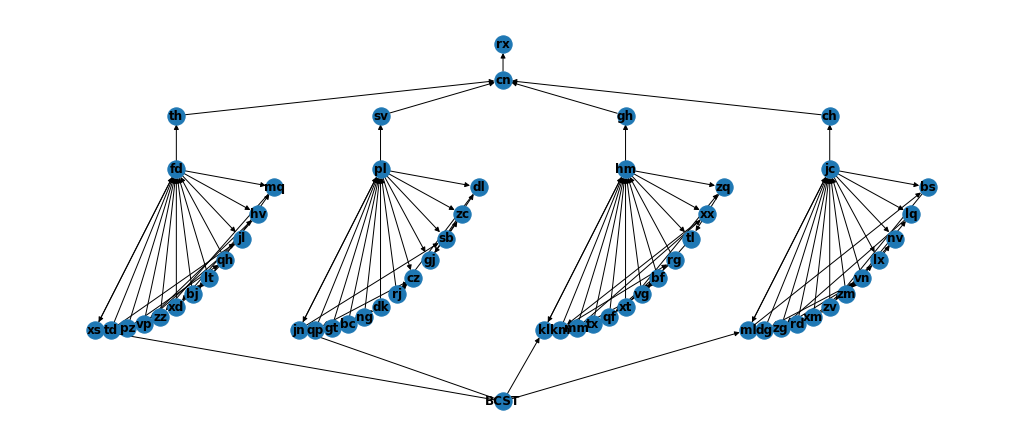

In [25]:
# Using networkx to explore the graph structure.  After several iterations,
# I discovered this essential structure.

G = nx.DiGraph()
for v in V:
    for n in V[v].N:
        G.add_edge(v,n)

start, end = 'BCST','rx'
pos = {end:[50,100], start:[50,0]}
next = list(G.predecessors(end))[0]
pos[next] = [50,90]

parts = {1:10, 2:35, 3:65, 4:90}
for n, p in zip(G.predecessors(next),(1,2,3,4)):
    pos[n] = [parts[p], 80]
    next = list(G.predecessors(n))[0]
    pos[next] = [parts[p],65]

    for n2 in G.predecessors(next):
        if n2 in G['BCST']:
            pos[n2] = [parts[p]-10,20]
            break

    for i, n3 in enumerate([x for x in tt.chain(G.predecessors(next), G.successors(next)) if x not in pos.keys()]):
        pos[n3] = [parts[p]-10+2*(i+1), 20 + (i*i)/2.5]

plt.figure(3,figsize=(14,6)) 
nx.draw(G, pos, with_labels=True, font_weight='bold') 
plt.show()


In [26]:
# The ten nodes at the top are the conjunction nodes and the output node 'rx'.
# The broadcaster node is at the bottom (the button is not listed).  The
# remainder are flipflop nodes.

# So, rx has one input (cn) which must send a 'L' pulse.  It (cn) has four
#  inputs (th sv gh ch) which all must send an 'H' pulse.  In turn, each of
#  those inputs (th sv gh ch) receives one input (fd pl hm jc, respectively)
#  from which they (th sv gh ch) all must receive an 'L' pulse.  Those four
#  inputs (fd pl hm jc) have 9, 7, 9, and 8 inputs respectively.

# I assume the problem has a solution so I decided to see if I could
#  determine how frequently fd pl hm and jc send low pulses and try to
#  assess whether this is eventually periodic with a low number of
#  button pushes between periods.  This was the case for all four.
#  Moreover, each period was the same for every iteration, which means
#  there is no run up to determine.

# Once the four periods are determined, the LCM of all four should give
#  the desired result.  If there was a runup, the CRT could be applied
#  to get the common modulus.  Anyway, assuming all these assumptions are
#  the same across inputs, this code that should give an answer to part B.

end = 'rx'
next = list(G.predecessors(end))[0]
theFour = {x:None for x in G.predecessors(next)}

V = parse_input(lines)   # Reset state
numIterations = 10000   # This should be enough, may need to increase.
for i in range(numIterations):
    press_button(V)
    notDone = [k for k, v in theFour.items() if v == None]
    for v in notDone:
        if V[v].L == 1:
            theFour[v] = i+1
    if len(notDone) == 0:
        break

zVals = [0,0,0,0]
moduli = [v for v in theFour.values()]
if None in moduli:
    logging.error("Increase numIterations.  At least one period not found.")
r, m = zVals[0], moduli[0]
for rk, mk in zip(zVals[1:], moduli[1:]):
    r, m = chinese_remainder_theorem(r, m, rk, mk)
partB = m
logging.info("theFour {}".format(theFour,))
logging.info("20b. Minimum button pushes before 'rx' receives low puls: {}".format(partB,))  #243902373381257

2023-12-28 03:38:04 INFO: theFour {'th': 3947, 'sv': 4001, 'gh': 3943, 'ch': 3917}
2023-12-28 03:38:04 INFO: 20b. Minimum button pushes before 'rx' receives low puls: 243902373381257


# 21.  Step Counter

## 21a.  How many plots reached after 64 steps?

## 21b.  How many plots reached after 26501365 steps?

I use a $4$-tuple to track location, $(bigR, bigC, r, c)$ where $bigR$ and
$bigC$ are the row and column on the infinite plane of maps, with
$(bigR,bigC) == (0,0)$ being the map that holds the start location.
Additionally, $r$ and $c$ are the location index on the $(bigR, bigC)$ map.
To add locations, I only need to consider each location once and add
its neighbors.  All visited locations get added to the visited.
When it is time to count the number of possible locations after $s$
steps, use the parity of the sum of each $4$-tuple location in visited
and count only those that match sum(start)$ + s$.  This works on the
infinite plane because the maps have an odd length.  If the maps
have an even length, then just summing $r$ and $c$ would work.

For part A, the number of steps doesn't actually reach the edge of the
board.  So just run it until it completes and count the number of steps.

For part B, because the number of steps is quite large, run the 
algorithm only a little ways out and then compute the solution.
This works nicely since number of steps takes the walker right to the
edge of each board and this is always the same since the row and column
that contain 'S' are devoid of rocks, as are the edges of the board.
When the elf gets to the edge of the board, there are 15 different
types boards that can be found on the plane.  Examining $2.5*n$ steps 
gives the following configuration centered around $(bigR, bigC) == (0,0)$

<table>
    <tr>
        <td> .. </td><td> ul </td><td> tp </td><td> ur </td><td> .. </td>
    </tr>
    <tr>
         <td> ul </td><td> UL </td><td> XX </td><td> UR </td><td> ur </td>
    </tr>
    <tr>
         <td> lt </td><td> XX </td><td> YY </td><td> XX </td><td> rt </td>
    </tr>
    <tr>
         <td> ll </td><td> LL </td><td> XX </td><td> LR </td><td> lr </td>
    </tr>
    <tr>
         <td> .. </td><td> ll </td><td> bt </td><td> lr </td><td> .. </td>
    </tr>
</table>

The '..' indicate a board the elf could not reach with $2.5*n$ steps, so
counts on those boards are 0.  The elf could reach to the outer edge
of each of top (tp), bottom (bt), left (lt), or right (rt).  The elf
could reach a little bit on the lower right of the ul boards and
those boards will have the same squares in visited.  Similarly, it 
could reach the "inner" corners (corners closest to the start) of 
each of the boards labeled ur, ll, and lr and boards with the same 
label will again have the same squares in visited.  The boards UL, UR
LL, and LR will have most of the board visited with the exception of
the farthest corner from the start.  Finally, the XX and YY boards
will have all squares in visited, but the parity of the boards will
be different when computing the final locations.

Examining out to 3.5*n steps gives
<table>
    <tr>
        <td> .. </td><td> .. </td><td> ul </td><td> tp </td><td> ur </td><td> .. </td><td> .. </td>
    </tr>
    <tr>
        <td> .. </td><td> ul </td><td> UL </td><td> XX </td><td> UR </td><td> ur </td><td> .. </td>
    </tr>
    <tr>
        <td> ul </td><td> UL </td><td> XX </td><td> YY </td><td> XX </td><td> UR </td><td> ur </td>
    </tr>
    <tr>
        <td> lt </td><td> XX </td><td> YY </td><td> XX </td><td> YY </td><td> XX </td><td> rt </td>
    </tr>
    <tr>
        <td> ll </td><td> LL </td><td> XX </td><td> YY </td><td> XX </td><td> LR </td><td> lr </td>
    </tr>
    <tr>
        <td> .. </td><td> ll </td><td> LL </td><td> XX </td><td> LR </td><td> lr </td><td> .. </td>
    </tr>
    <tr>
        <td> .. </td><td> .. </td><td> ll </td><td> bt </td><td> lr </td><td> .. </td><td> .. </td>
    </tr>
</table>

From this, one can determine a formula for $(g + .5)*n$ steps.
See formula in get_part_B_value where
$$ends   = tp + lt + bt + ur\\
  smalls = ul + ll + lr + ur\\
  larges = UL + LL + LR + UR\\
$$

In [27]:
filename = 'prob21input.txt'
lines = get_string_input(filename)

M = [l for l in lines]
n, m = len(M), len(M[0])
assert n == m
for i, row in enumerate(M):
    if row.find('S') != -1:
        start = (i, row.find('S'))
        break
start = (0,0,start[0],start[1])


def get_part_B_value(g, YY, XX, larges, smalls, ends):
    return (g-1)*(g-1)*YY + g*g*XX + (g-1)*larges + g*smalls + ends 

locs = set()
locs.add(start)
queue, newQueue = [start], []
numStepsA = 64
numStepsB = 26501365
for s in range(numStepsB):
    newQueue = []
    for bigR, bigC, r, c in queue:
        for newR, newC in [(r,c+1), (r,c-1), (r+1,c), (r-1,c)]:
            newBigR, newBigC = bigR, bigC
            if newR < 0 or newR >= n:
                newBigR = bigR-1 if newR < 0 else bigR+1
                newR = newR % n
            if newC < 0 or newC >= m:
                newBigC = bigC-1 if newC < 0 else bigC+1
                newC = newC % m
            newLoc = (newBigR, newBigC, newR,newC)

            if newLoc not in locs and M[newR][newC] != '#':
                locs.add(newLoc)
                newQueue.append(newLoc)
    queue = newQueue
    
    if s == numStepsA -1:
        logging.info("Computing solution for part A")
        parity = (sum(start) + numStepsA) % 2
        partA = len([loc for loc in locs if sum(loc) %2 == parity])

    if s+1 == math.floor(2.5*n):
        logging.info("Computing needed values for part B")
        minBigR = min([loc[0] for loc in locs])
        maxBigR = max([loc[0] for loc in locs])
        minBigC = min([loc[1] for loc in locs])
        maxBigC = max([loc[1] for loc in locs])
        parity = (sum(start) + s+1) % 2

        # After 2.5*n steps
        # .. ul tp ur ..
        # ul UL XX UR ur
        # lt XX YY XX rt
        # ll LL XX LR lr
        # .. ll bt lr ..

        # After 3.5*n steps
        # .. .. ul tp ur .. ..
        # .. ul UL XX UR ur ..
        # ul UL XX YY XX UR ur
        # lt XX YY XX YY XX rt
        # ll LL XX YY XX LR lr
        # .. ll LL XX LR lr ..
        # .. .. ll bt lr .. ..

        tp = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == minBigR and loc[1] == 0])
        bt = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == maxBigR and loc[1] == 0])
        lt = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == 0 and loc[1] == minBigC])
        rt = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == 0 and loc[1] == maxBigC])
        ends = tp + bt + lt + rt

        ul = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == minBigR and loc[1] == -1])
        ur = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == minBigR and loc[1] == 1])
        ll = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == maxBigR and loc[1] == -1])
        lr = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == maxBigR and loc[1] == 1])
        smalls = ul + ur + ll + lr

        UL = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == minBigR+1 and loc[1] == -1])
        UR = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == minBigR+1 and loc[1] == 1])
        LL = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == maxBigR-1 and loc[1] == -1])
        LR = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == maxBigR-1 and loc[1] == 1])
        larges = UL + UR + LL + LR

        YY = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == minBigR+2 and loc[1] == 0])
        XX = len([loc for loc in locs if sum(loc) %2 == parity and loc[0] == minBigR+1 and loc[1] == 0])
        break

    if len(queue) == 0:
        break

assert (numStepsB - n//2) % n == 0
g = (numStepsB - n//2)//n
partB = get_part_B_value(g, YY, XX, larges, smalls, ends)

logging.info("21a. Locations after {} steps: {}".format(numStepsA, partA))  # 3768
logging.info("21b. Locations after {} steps: {}".format(numStepsB, partB,))  # 627960775905777

2023-12-28 03:38:04 INFO: Got 131 lines from prob21input.txt.
2023-12-28 03:38:04 INFO: Computing solution for part A
2023-12-28 03:38:04 INFO: Computing needed values for part B
2023-12-28 03:38:05 INFO: 21a. Locations after 64 steps: 3768
2023-12-28 03:38:05 INFO: 21b. Locations after 26501365 steps: 627960775905777


# 22.  Sand Slabs

## 22a.  How many blocks could be disintegrated without causing other blocks to fall?

## 22b.  What is the sum of blocks that would fall if each block were removed by itself?


In [28]:
filename = 'prob22input.txt'
lines = get_string_input(filename)

# In my approach to part A, I anticipated that in part B the blocks could
# become untenably large.  So, I opted to represent blocks by a sequence
# of three ranges, one in each primary direction.  This makes the code a
# little more complicated but would have allowed me to deal with much larger
# blocks falling much greater distances.  However, part B did not go in
# that direction, but rather than "change horses midstream" I decided to
# complete part B without rewriting part A.

blocks = []
for l in lines:
    s1, s2 = l.split('~')
    s1 = [int(s) for s in s1.split(',')]
    s2 = [int(s) for s in s2.split(',')]
    s1, s2 = sorted([s1, s2], key=lambda x: x[2])  
    blocks.append([[s1[0], s2[0]], [s1[1], s2[1]], [s1[2], s2[2]]] )
blocks = sorted(blocks, key=lambda x: x[2])  # sort blocks by smallest z-value
# Finished parsing input
# blocks = [[xRange, yRange, zRange], [xRange, yRange, zRange],...]
#   where each range = [start, end]; with start and end being integers

def do_dims_overlap(range1, range2):
    ''' Return boolean indicating if range1 and range2 have any overlap.'''
    retval = False
    sD1, sD2 = sorted(range1)   # e.g. [1,1]
    tD1, tD2 = sorted(range2)   # e.g. [0,2]
    if sD1 <= tD1 <= sD2 or tD1 <= sD1 <= tD2:
        retval = True
    return retval

def do_blocks_overlap_in_plane(b1, b2):
    ''' Return boolean indicating if b1 and b2 overlap in the x-y plane.'''
    retval = False
    xB1, yB1, _ = b1  #e.g. [1,1],[0,2],[1,1]
    xB2, yB2, _ = b2  #e.g. [0,2],[1,1],[2,2]
    if do_dims_overlap(xB1, xB2) and do_dims_overlap(yB1, yB2):
        retval = True
    return retval

def get_distance_to_fall(block, landed):
    ''' Return a distance that block can fall before hitting the ground
         or landing on some other block in landed.
    '''
    retval = block[2][0] - 1  # Distance block would fall to hit ground
    for landBlock in sorted(landed, key=lambda x: x[2][1], reverse=True):
        if block[2][0] > landBlock[2][1]:
            if do_blocks_overlap_in_plane(block, landBlock):
                retval = min(retval, block[2][0] - landBlock[2][1] - 1)
                break
    return retval

def get_supports_and_carry_info(blocks):
    ''' Return two dictionaries that describe the direct support relationship
         between blocks in blocks.  The relationship is a many to many
         mapping so it is easier to hold this information in two dicts.
        Note: "direct support" is not considered transitive; blocks must be
          1 unit apart in zValue.
        sups[i] = [blocks supporting i]; carry[i] = [blocks supported by i]

    '''
    sups, carry = dict(), dict()
    blocks = sorted(blocks, key=lambda x: x[2][0])  # Helps with efficiency
    for i, b in enumerate(blocks):
        sups[i] = []
        for j, s in enumerate(blocks[:i]):
            if s[2][1]+1 == b[2][0] and do_blocks_overlap_in_plane(b, s):
                if carry.get(j,None) == None:
                    carry[j] = []
                carry[j].append(i)
                sups[i].append(j)
    return sups, carry

def get_num_blocks_supported(block, sups, carry):
    '''Return the number of blocks that would fall if block were removed.
        This type of supporting need not be direct.
    '''
    retval = 0
    gone, toDropQueue = set(), [block]
    while len(toDropQueue) > 0:
        drop = toDropQueue.pop(0)
        gone.add(drop)
        for c in carry.get(drop,[]):  # examine each c carried by drop
            if c not in gone and all([s in gone for s in sups[c]]):
                toDropQueue.append(c)
    retval = len(gone)-1  # do not count initial block
    return retval

# Drop blocks into landed
landed = []
for b in blocks:
    d = get_distance_to_fall(b, landed)
    newB = [b[0], b[1], [b[2][0]-d, b[2][1]-d]]
    landed.append(newB)

sups, carry = get_supports_and_carry_info(landed)
# sups[i] = [indices of blocks supporting block i] 
# carry[i] = [indices blocks supported by block i]
numFixed = len(set([v[0] for v in sups.values() if len(v) == 1]))
partA = len(landed) - numFixed
partB = sum([get_num_blocks_supported(b, sups, carry) for b in carry.keys()])

logging.info("22a. Number of disintegratable blocks: {}".format(partA,))
logging.info("22b. Total blocks that would fall: {}".format(partB,))

2023-12-28 03:38:05 INFO: Got 1430 lines from prob22input.txt.
2023-12-28 03:38:05 INFO: 22a. Number of disintegratable blocks: 485
2023-12-28 03:38:05 INFO: 22b. Total blocks that would fall: 74594


# 23.  A Long Walk

## 23a.  What is the longest path in the weighted DAG?

## 23b.  What is the longest path from start to end ignoring the edge directionality?

2023-12-28 03:38:05 INFO: Got 141 lines from prob23input.txt.


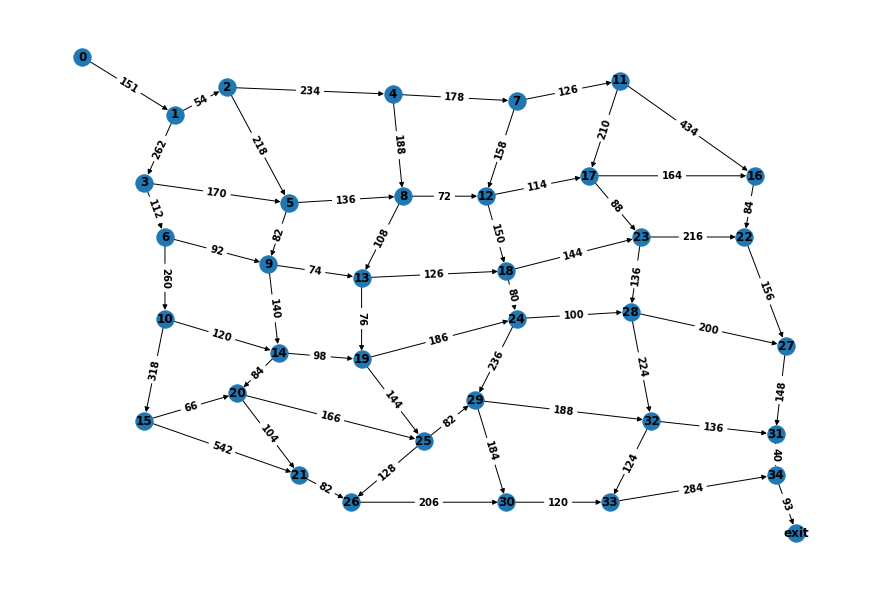

2023-12-28 03:38:06 INFO: 23a. Longest path in DAG: 2430
2023-12-28 03:38:59 INFO: 23b. Longest path in simple graph: 6534


In [29]:
filename = 'prob23input.txt'
lines = get_string_input(filename)

M = [l for l in lines]

def get_walk_neighbors(loc, M):
    retval = []
    totalCount = 0
    r, c = loc
    for newR, newC in [(r,c+1),(r,c-1),(r+1,c),(r-1,c)]:
        if 0 <= newR < len(M) and 0 <= newC < len(M[0]):
            char = M[newR][newC]
            if char != '#':
                totalCount += 1
            if char == '.':
                retval.append((newR,newC))
            elif char == '>' and c < newC:
                retval.append((newR,newC))
            elif char == '<' and c > newC:
                retval.append((newR,newC))
            elif char == '^' and r > newR:
                retval.append((newR,newC))
            elif char == 'v' and r < newR:
                retval.append((newR,newC))
    return totalCount, retval


def get_longest_dist_end(end, path, curV, pathDist, G):
    ''' Recursively search the graph G for the longest path to end.
        
        Arguments:
            end: name of ultimate destination vertex
            path: a set (unordered) of vertices previously added to path
            curV: (r,c) location of the current vertex
            pathDist: integer distance traversed so mar.
            G:  A networkX graph;
            partB:  boolean indicating partB (True) or partA (fals9)

    '''
    retval = 0
    path.add(curV)    # Add to path, 
    for nbor in G[curV]:
        newDist = pathDist + G.get_edge_data(curV,nbor)['weight']
        if nbor not in path:
            retval = max(retval,newDist)
            if nbor != 'exit':
                retval = max(retval, get_longest_dist_end(end, path, nbor, newDist, G))
    path.remove(curV)  # Remove from path
    return retval

# Create DAG out of input... should work?
G = nx.DiGraph()
start = (0, M[0].index('.'))
order = 0  # also the name of the vertices
queue = [(0, start)]
vertexLocs = {start:0}
visited = set()

# Traverse map and condense into graph.  Add each corridor
#  as an edge in weighted DAG.  For each vertex in queue, walk
#  to its neighbors and add them to the queue.  Continue until
#  all edges traversed.
while len(queue) > 0:
    curV, vertexLoc = queue.pop(0)
    deg, Nv = get_walk_neighbors(vertexLoc, M)
    Nv = [u for u in Nv if u not in visited]  # remove paths already traversed
    for nbor in Nv:    # for each path extending from current vertex
        stepLoc, steps = nbor, 1
        while 1:   # Follow edge until stops or new vertex found
            deg, Nstep = get_walk_neighbors(stepLoc, M)
            Nstep = [u for u in Nstep if u not in visited and u != curV]
            if deg > 2:  # vertex found; add edge (curV, stepLoc) with weight steps
                vertexName = vertexLocs.get(stepLoc,None)
                if vertexName == None:   # vertex not found in previously
                    order += 1           #  get new name and save; add to queue
                    vertexName = order
                    vertexLocs[stepLoc] = vertexName
                    queue.append((vertexName,stepLoc))
                G.add_weighted_edges_from([(curV,vertexName,steps)])
                break
            elif len(Nstep) == 0:   # Dead end or exit?
                if stepLoc[0] == len(M) - 1:  # on last row? 
                    G.add_weighted_edges_from([(curV,'exit',steps)])
                    vertexLocs[stepLoc] = 'exit'
                break
            elif len(Nstep) > 0:     # Default case, continue walking
                visited.add(stepLoc) #  corridor until new vertex
                stepLoc = Nstep[0]   #  reached.
                steps += 1

# Output the graph created above so it can be examined.
pos = {k:[v[1],n-v[0]] for v, k in vertexLocs.items()}
labels = {e: G.get_edge_data(e[0],e[1])['weight'] for e in G.edges}
plt.figure(3,figsize=(12,8)) 
nx.draw(G, pos, with_labels=True, font_weight='bold', ) 
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_weight='bold', ) 
plt.show()

# Solve problem
partA = get_longest_dist_end('exit', set(), 0, 0, G)
logging.info("23a. Longest path in DAG: {}".format(partA,))  # 2430

# The graph is the same in part 2 it is just undirected.  The algorithm takes
#  much longer to run in this case.  Not sure how to reduce the runtime, of
#  if it is even possible.
GB = G.to_undirected() # Get undirected graph
partB = get_longest_dist_end('exit', set(), 0, 0, GB)
logging.info("23b. Longest path in simple graph: {}".format(partB,))  # 6534

# 24.  Never Tell Me The Odds

## 24a.  How many will pairs intersect in the given area?

## 24b.  What is the sum of the starting coordinates?

In [30]:
filename = 'prob24input.txt'
lines = get_string_input(filename)

myLines = []
for l in lines:
    vals = l.split(' @ ')
    x, y, z = [int(v) for v in vals[0].split(', ')]
    r, s, t = [int(v) for v in vals[1].split(', ')]
    myLines.append([[x,y,z],[r,s,t]])

def get_intersection(L, J):
    ''' Get the intersection of the lines L and J and return.
        No check is done here to ensure intersection is in the future.
    '''
    x, y, _ = L[0]  # starting location of L
    r, s, _ = L[1]  # velocity of L
    m1, b1 = s/r, y - s*x/r  # L is the line y = m1x + b1

    x, y, _ = J[0]  # starting location of J
    r, s, _ = J[1]  # velocity of J
    m2, b2 = s/r, y - s*x/r  # J is the line y = m2x + b2
    
    if m1 != m2:
        x = (b2 - b1)/(m1 - m2)
        y = m1*x + b1
    else:  
        return None
    return x, y

def will_rock_path_hit_loc(loc, rockPath):
    retval = False
    x, y, _ = rockPath[0]   # starting location of rock
    r, s, _ = rockPath[1]   # velocity of rock
    if ((x <= loc[0] and r >= 0) or (x >= loc[0] and r <= 0)):
        if ((y <= loc[1] and s >= 0) or (y >= loc[1] and s <= 0)):
            retval = True
    return retval

def in_range(loc, L, J):
    ''' Test that intersection location (loc) of L and J is in the
         desired area
    '''
    minXY, maxXY = 200000000000000, 400000000000000
    test1, test2, test3 = False, False, False
    if loc != None:
        if minXY <= loc[0] <= maxXY and minXY <= loc[1] <= maxXY:
            test1 = True
        test2 = will_rock_path_hit_loc(loc, L)
        test3 = will_rock_path_hit_loc(loc, J)
    return test1 and test2 and test3

partA = 0
for L, J in tt.combinations(myLines, 2):
    if in_range(get_intersection(L, J), L, J):
        partA += 1

logging.info("24a. Number of collisions: {}".format(partA,))  # 18651

2023-12-28 03:38:59 INFO: Got 300 lines from prob24input.txt.
2023-12-28 03:38:59 INFO: 24a. Number of collisions: 18651


I went through a couple iterations for part B.  Let $X$,$Y$,$Z$ be
 the initial starting position of the thrown rock and let it
 have velocity $a$,$b$,$c$.  Further let the rock $i$ be described
 by position $x_i$, $y_i$, $z_i$ with velocity $a_i$, $b_i$, $c_i$ 

1) This gives a series of equations (1a):

$$X + t_i(a) = x_i + t_i(a_i)\\
  Y + t_i(b) = y_i + t_i(b_i)\\
  Z + t_i(c) = z_i + t_i(c_i)\\
$$
where $t_i$ is the time for the thrown rock to hit with rock $i$.
These three equations with seven variables can be condensed
into three others that eliminate ti since (1b)
$$t_i = (X - x_i)/(a_i - a)\\
  t_i = (Y - y_i)/(b_i - b)\\
  t_i = (Z - z_i)/(c_i - c)\\
$$
then (1c)
$$(X - xi)/(ai - a) == (Y - yi)/(bi - b) == (Z - zi)/(ci - c)$$
There are more than enough equations to solve a system with six
unknowns.  One could use an algebra package, but that seems kind
of lame.  One could code up a solver, but that does not seem fun.

I fiddled with the equations in (1c) to see if I could find something
simple, but the solution just looks ugly and I abandoned this approach.

Approach 1 does not take into account that the six variables are
integers nor does it take into account that each $t_i$ is a positive
integer.  There is no code below associated with this approach.

2) Consider changing the reference so that the thrown rock does
not actually move.  Then all the points would be represented as (2a)
$$x_i, y_i, z_i \textrm{ @ } a_i-a, b_i-b, c_i-c$$
 (note $a$, $b$, and $c$ are unknown)
Each of these new points must collide with the "thrown" rock (2b)
$$X, Y, Z \textrm{ @ } a-a, b-b, c-c = X, Y, Z \textrm{ @ } 0, 0, 0$$
which is no longer moving.  That is, each equation in (2a) must
pass through the solution $X, Y, Z$.  Since these are linear equations
they must all intersect at the solution and only at the solution.
Moreover, that will be the only intersection for all pairs of equations.

Working under the assumption that the solution is findable in a
reasonable amount of time, I decided to "guess and check" for the
values $a$, $b$, and $c$.  Actually, with this approach, one can initially
ignore the third dimension entirely and just search for an $a$ and $b$
that work in those two dimensions.  Once $a$ and $b$ are found (as well)
as $X$ and $Y$) then repeating the process with $a$ and $c$ or $b$ and $c$ to
find $c$ (and $Z$) can be done.  That is the approach taken in the first
cell below.

One note, the numbers are large enough that taking a straightforward
$y = mx + b$ approach to finding the lines was problematice due to
division roundoff error.  Therefore, I tried to only do division
once and then never reuse those variables.  Moreover, since the
solutions are supposed to be integers, I rounded the intersection
points for each pair of equations.  While this does change the
intersection points for "guessed" values that are incorrect, the
points will still not be equal across all equations so the rounding
will not cause harm in those cases.

3) Since each equation in (2a) must pass through X, Y, Z, then for
each $i$ there exists $t_i$ such that (3a)
$$x_i + t_i(a_i - a) = X$$
and therefore (3b)
$$x_i \textrm{ \% }(a_i - a) = X \textrm{ \% } (a_i - a)$$
and letting $r_i = x_i \textrm{ \% } (a_i - a)$ and $m_i = (a_i - a)$ gives (3c)
$$r_i = X \textrm{ \% } m_i$$
So, assuming for the moment $a$ is known, each $r_i$ and $m_i$ could be
computed and the Chinese Remainder Theorem can be applied to solve
for X.  It seems unlikely a solution would exist if the wrong $a$
is selected, so if we find an $a$ for which a solution exists, then
theoretically that solution it is congruent to the true solution.  In
practice, the common modulus becomes ridiculously large so it turns
out to be the actual solution.

So, one can again "guess and check" values of a until a value is found
that works and gives a solution.  That approach is done in the following cell. 


In [31]:

filename = 'prob24input.txt'
lines = get_string_input(filename)

myLines = []
for l in lines:
    vals = l.split(' @ ')
    pos = [int(v) for v in vals[0].split(', ')]
    vel = [int(v) for v in vals[1].split(', ')]
    myLines.append([pos,vel])

def get_integer_intersection(L, J):
    ''' Return the x-y point of intersection for the 3-dimensional
         points contained in L, J; rounded to the nearest integer
         coordinates.
        L = [x1,y1,z1], [a1,b1,c1] where x1,y1,z1 is a position and
              a1,b1,c1 is a direction the line travels        
        J = [x2,y2,z2], [a2,b2,c2] where x2,y2,z2 is a position and
              a2,b2,c2 is a direction the line travels  
        To deal with nontrivial roundoff errors, I had to avoid using
         division as much as possible, so the equations are not
         very easy to follow.  Hopefully the comments help.
    '''
    x1, y1, _ = L[0]  # Not using z dimension
    a1, b1, _ = L[1]
    x2, y2, _ = J[0]
    a2, b2, _ = J[1]

    # find m and k to get slope-intercept form of line
    #m1 = b1/a1;    k1 = y1 - m1*x1 = y1 - x1*b1/a1
    #m2 = b2/a2    #k2 = y2 - m2*x2 = y1 - x1*b2/a2

    # To avoid division, find equation indicating k1 == k2
    # if k1 == k2
    # then     y1 - b1/a1*x1 == y2 - b2/a2*x2
    #          y1*a1 - b1*x1 == y2*a1 - b2*a1/a2*x2
    #     a2*(y1*a1 - b1*x1) == a1*(y2*a2 - b2*x2)
    k1_equals_k2 = a2*(y1*a1 - b1*x1) == a1*(y2*a2 - b2*x2)

    # To avoid division, find equation indicating m1 == m2
    # if m1 == m2
    # then     b1/a1 == b2/a2
    #          a2*b1 == a1*b2
    m1_equals_m2 = a2*b1 == a1*b2 

    # Compute intersection point between two lines; handle several
    #  special cases of no-slopes and parallel lines first.  The
    #  final else statement is the standard intersection between
    #  two "nice" lines with real slopes that are not equal.
    if a1 == 0 and a2 == 0 and k1_equals_k2:
        x, y = 'inf', 'inf'  # same line
    elif a1 == 0 and a2 == 0 and not k1_equals_k2:
        x, y = None, None    # unequal parallel lines
    elif a1 == 0:
        x, y = x1, round(y2 + (x1 - x2)*b2/a2)
    elif a2 == 0:
        x, y = x2, round(y1 + (x2 - x1)*b1/a1)
    elif m1_equals_m2 and k1_equals_k2:
        x, y = 'inf', 'inf'  # same line
    elif m1_equals_m2 and not k1_equals_k2: 
        x, y = None, None    # unequal parallel lines
    else:
        # Solve for x and y; allow only single division and apply it last
        # Solve for x; y2 == y1
        #       m2*x + k2 == m1*x + k1
        #   x == (k2 - k1)/(m1 - m2)
        #   x == ((y2 - x2*b2/a2) - (y1 - x1*b1/a1)/(b1/a1 - b2/a2)
        #   x == ((a1*a2*y2 - a1*b2*x2) - (a1*a2*y1 - a2*b1*x1)/(a2*b1 - a1*b2)
        x = round((a1*a2*(y2-y1) + b1*a2*x1 - a1*b2*x2)/(a2*b1 - a1*b2))

        # Solve for y; x2 == x1
        #     (y - k2)/m2 == (y - k1)/m1
        #   y == (m1k2 - m2k1)/(m1 - m2)
        #   y == ((b1/a1)(y2 - x2*b2/a2) - (b2/a2)(y1 - x1*b1/a1)/(b1/a1 - b2/a2)
        #   y == ((b1)(a2*y2 - x2*b2) - (b2)(a1*y1 - x1*b1)/(a1*b1 - a1*b2)
        #   y == (a2*b1*y2 - b1*b2*x2 - a1*b2*y1 + b1*b2*x1)/(a1*b1 - a1*b2)
        #   y == (b1*b2(x1-x2) + a2*b1*y2 - a1*b2*y1)/(a1*b1 - a1*b2)
        y = round((b1*b2*(x1-x2) - a1*b2*y1 + a2*b1*y2)/(a2*b1 - a1*b2))
    return x, y         

bound = 500

for a, b in tt.product(range(-bound,bound),range(-bound,bound)):
    theX, theY = None, None
    for R, S in tt.combinations(myLines, 2):
        P = [[R[0][0], R[0][1], R[0][2]], [R[1][0] - a, R[1][1] - b, R[1][2]]]
        Q = [[S[0][0], S[0][1], S[0][2]], [S[1][0] - a, S[1][1] - b, S[1][2]]]

        X, Y = get_integer_intersection(P, Q)
        if X == 'inf':
            pass  # P, Q are the same line; just move on
        elif X == None:
            theX, theY = None, None
            break
        elif theX == None:
            theX, theY = X, Y
        elif X != 'inf' and (theX != X or theY != Y):
            theX, theY = None, None
            break

    if theX != None:
        logging.info("EUREKA {} {}".format(a, b))
        break

for c in range(-bound,bound):
    theZ = None
    for R, S in tt.combinations(myLines, 2):
        # Cheating; swap y and z values to get intersection in x-z plane
        P = [[R[0][0], R[0][2], R[0][1]], [R[1][0] - a, R[1][2] - c, R[1][1]]]
        Q = [[S[0][0], S[0][2], S[0][1]], [S[1][0] - a, S[1][2] - c, S[1][1]]]

        newX, Z = get_integer_intersection(P, Q)
        if Z == 'inf':
            pass  # P, Q are the same line; just move on
        elif Z == None:
            theZ = None
            break
        elif theZ == None:
            theNewX, theZ = newX, Z
        elif Z != 'inf' and (theNewX != newX or theZ != Z):
            theZ = None
            break

    if theZ != None:
        logging.info("EUREKA {}".format(c,))
        break
logging.info("a = {} b = {} c = {}".format(a, b, c))
logging.info("X = {} Y = {} Z = {}".format(theX, theY, theZ))
assert theX == theNewX
partB = theX + theY + theZ

logging.info("24b. Sum of starting coordinates: {}".format(partB,))  # 546494494317645

2023-12-28 03:38:59 INFO: Got 300 lines from prob24input.txt.


2023-12-28 03:39:03 INFO: EUREKA 133 278
2023-12-28 03:39:03 INFO: EUREKA 85
2023-12-28 03:39:03 INFO: a = 133 b = 278 c = 85
2023-12-28 03:39:03 INFO: X = 200027938836082 Y = 127127087242193 Z = 219339468239370
2023-12-28 03:39:03 INFO: 24b. Sum of starting coordinates: 546494494317645


In [32]:
filename = 'prob24input.txt'
lines = get_string_input(filename)

myLines = []
for l in lines:
    vals = l.split(' @ ')
    pos = [int(v) for v in vals[0].split(', ')]
    vel = [int(v) for v in vals[1].split(', ')]
    myLines.append([pos,vel])

def search_dim_start(dim, bound, myLines):
    ''' Search for value v in [-bound,bound) that provides a solution
         in dimension dim.  If found, return the found solution.  If not
         return None
        Arguments:
            dim = integer in [0,1,2]
            bound = integer
            myLines = list of rock paths [[x,y,z],[a,b,c]] 
    '''
    retval = None
    for v in range(-bound,bound):  # Search for value v within bounds
        retval, theMod = None, None
        for R in myLines:
            pi, mi = R[0][dim], abs(R[1][dim] - v)
            if mi == 0:
                pass  # ignore, this is the trivial case
            else:
                ri = pi % mi   # ri = xi % mi
                if retval == None:
                    retval, theMod = ri, mi  
                else:
                    gcd, _, _ = ext_euclidean_alg(mi, theMod)
                    if ri % gcd == retval % gcd:
                        retval, theMod = chinese_remainder_theorem(ri, mi, retval, theMod)
                        #logging.info("retval {}".format(retval,))
                    else:
                        retval, theMod = None, None
                        break
        if retval != None:
            break
    return retval

bound = 10000
theX = search_dim_start(0, bound, myLines)
theY = search_dim_start(1, bound, myLines)
theZ = search_dim_start(2, bound, myLines)
partB = theX + theY + theZ
logging.info("X = {} Y = {} Z = {}".format(theX, theY, theZ))
logging.info("24b. Sum of starting coordinates: {}".format(partB,))  # 546494494317645

2023-12-28 03:39:03 INFO: Got 300 lines from prob24input.txt.
2023-12-28 03:39:04 INFO: X = 200027938836082 Y = 127127087242193 Z = 219339468239370
2023-12-28 03:39:04 INFO: 24b. Sum of starting coordinates: 546494494317645


# 25.  Snowverload

## 25a.  After removing the three edges that separate the graph, what is the product of the orders of the two components?

## 25b.  Free Star!

In [33]:
filename = 'prob25input.txt'
lines = get_string_input(filename)

# I phoned it in and just used networkX to do all the work.
# It's Christmas, I have other things I want to do.

G = nx.Graph()
for l in lines:
    u, Nu = l.split(': ')
    for v in Nu.split(' '):
        G.add_edge(u,v)

sizeG = len(G.edges())
S = nx.minimum_edge_cut(G)
assert len(S) == 3
for e in S:
    G.remove_edge(e[0],e[1])
assert nx.number_connected_components(G) == 2
partA = product([len(Vi) for Vi in nx.connected_components(G)])

logging.info("25a. Product of two component orders: {}".format(partA,))
logging.info("25b. Free Star!")

2023-12-28 03:39:04 INFO: Got 1211 lines from prob25input.txt.
2023-12-28 03:39:08 INFO: 25a. Product of two component orders: 552695
2023-12-28 03:39:08 INFO: 25b. Free Star!
